## Import library

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import xarray as xr
import xclim
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [209]:
## Set working directory
os.chdir('/mys3bucket/Biascorrected/')

## Import Historical cooling degree days file based on ERA5

In [210]:
ref_ctrl=xr.open_dataset('/mys3bucket/Biascorrected/CDD_Daily_air_temperature_at_2_metres_1970_2000_WA.nc')
ref_ctrl=ref_ctrl.sel(time=slice("1971-01-01", "2000-12-31"))
## The reference is choosed from 1971 and end in 2000 to avoid clashing year with the earliest Global warming levels reach.

In [211]:
ref_ctrl

<xarray.Dataset>
Dimensions:              (lat: 121, lon: 181, time: 30)
Coordinates:
  * time                 (time) datetime64[ns] 1971-01-01 ... 2000-01-01
  * lon                  (lon) float32 -20.0 -19.75 -19.5 ... 24.5 24.75 25.0
  * lat                  (lat) float32 30.0 29.75 29.5 29.25 ... 0.5 0.25 0.0
Data variables:
    cooling_degree_days  (time, lat, lon) float32 ...

In [212]:
ref_ctrl.cooling_degree_days.mean(['lon','lat']).to_dataframe().head()

cooling_degree_days
time                           
1971-01-01           691.800842
1972-01-01           766.921509
1973-01-01           817.553101
1974-01-01           674.414734
1975-01-01           661.497375

## Export files yearly CDD to CSV in the output folder

In [213]:
ref_cdd=ref_ctrl.cooling_degree_days.mean(['lon','lat']).to_dataframe()

In [214]:
## Export historical cdd (1971-2005) to csv
ref_cdd.to_csv('/mys3bucket/cdd_output/ref_cdd.csv')

## Import future CDD under RCP 4.5 and RCP 8.5

### Import Multi-model model mean CDD

In [215]:
fut_rcp45=xr.open_dataset('/mys3bucket/Biascorrected/MMM_CDD_tas_day_BCSD_rcp45_r1i1p1_2006_2100_WAfrik_rg_Bias-eqm.nc')
fut_rcp85=xr.open_dataset('/mys3bucket/Biascorrected/MMM_CDD_tas_day_BCSD_rcp85_r1i1p1_2006_2100_WAfrik_rg_Bias-eqm.nc')

In [216]:
fut_rcp85

<xarray.Dataset>
Dimensions:              (lat: 121, lon: 181, time: 94)
Coordinates:
  * time                 (time) datetime64[ns] 2006-01-01 ... 2099-01-01
  * lon                  (lon) float32 -20.0 -19.75 -19.5 ... 24.5 24.75 25.0
  * lat                  (lat) float32 30.0 29.75 29.5 29.25 ... 0.5 0.25 0.0
Data variables:
    cooling_degree_days  (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Sat Jan 22 19:31:53 2022: cdo -O -ensmean /mys3bucket/Biasc...
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

In [217]:
## Combine models RCPs

In [218]:
from glob import glob
# list of rcp4.5 and rcp8.5 cdd files per model
rcp45_paths=glob('/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp45_r1i1p1_*_2006_*_WAfrik_rg_Bias-eqm.nc')
rcp85_paths=glob('/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp85_r1i1p1_*_2006_*WAfrik_rg_Bias-eqm.nc') 

In [219]:
rcp45_paths

['/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp45_r1i1p1_CNRM-CM5_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp45_r1i1p1_CSIRO-Mk3-6-0_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp45_r1i1p1_GFDL-ESM2M_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp45_r1i1p1_IPSL-CM5A-MR_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp45_r1i1p1_MIROC5_2006_2099_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp45_r1i1p1_MPI-ESM-LR_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp45_r1i1p1_NorESM1-M_2006_2100_WAfrik_rg_Bias-eqm.nc']

In [220]:
NEX_name=['CNRM','CSIRO','GFDL','IPSL','MIROC5','MPI','NorESM1'] # Models prefix labels

## Computation of the relative Change of the CDD over RCP 4.5 and RCP 8.5

In [221]:
# Function to process each model : Open, masking, conversion to degree, tranform to dataframe
def pros_cor_models(path_dat,list_model,varname,expr):
    df=pd.DataFrame()
    
    for i,link in enumerate(path_dat):
        cor_model=xr.open_dataset(link)
        
        if (varname=='tas'):cor_model=cor_model.drop(['height'])
        
        # Crop datasest around the mask
        year_mod=cor_model[str(varname)].groupby('time.year').mean(['lon','lat'])
        
        # convert to dataframe
        mdf=year_mod.to_dataframe().reset_index(drop=True)
        
        # Create a new colunm with data
        df[str(expr+'_'+list_model[i])]=mdf[str(varname)]
    
    return df

In [222]:
cdd_rcp45=pros_cor_models(rcp45_paths,NEX_name,'cooling_degree_days','CDD')
cdd_rcp45['MEAN'] = cdd_rcp45.mean(axis=1)

In [223]:
cdd_rcp45

CDD_CNRM    CDD_CSIRO     CDD_GFDL     CDD_IPSL   CDD_MIROC5  \
0    878.759712   901.846996   930.015927   898.603620   938.771652   
1    823.362098   865.062210  1020.059048   823.469708   869.355889   
2    961.689024   937.078090   906.589109   921.217841   845.748391   
3    875.630058   859.640280  1017.662380   978.322378   927.091891   
4    881.064091   947.035688   977.526165   927.318953  1099.573941   
..          ...          ...          ...          ...          ...   
90  1423.649267  1721.162000  1489.937607  1696.832114  1524.891397   
91  1377.611999  1737.914019  1285.003540  1614.032247  1648.294228   
92  1382.467977  1740.197121  1326.782049  1549.830877  1600.506336   
93  1324.489457  1702.988097  1375.235060  1667.353220  1586.960664   
94  1366.952534  1722.422942  1200.878951  1556.948679          NaN   

        CDD_MPI  CDD_NorESM1         MEAN  
0    940.073071   893.837559   911.701219  
1    940.211553   879.600788   888.731613  
2   1008.697639   893.134246   924.879191  
3   1019.116230   946.059231   946.217493  
4   1030.912583   923.370988   969.543201  
..          ...          ...          ...  
90  1447.214228  1401.280590  1529.281029  
91  1346.316764  1335.625634  1477.828347  
92  1348.581430  1431.679044  1482.863548  
93  1389.338350  1406.667675  1493.290360  
94  1569.598554  1452.217382  1478.169840  

[95 rows x 8 columns]

In [224]:
rcp85_paths

['/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp85_r1i1p1_CNRM-CM5_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp85_r1i1p1_CSIRO-Mk3-6-0_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp85_r1i1p1_GFDL-ESM2M_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp85_r1i1p1_IPSL-CM5A-MR_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp85_r1i1p1_MIROC5_2006_2099_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp85_r1i1p1_MPI-ESM-LR_2006_2100_WAfrik_rg_Bias-eqm.nc',
 '/mys3bucket/Biascorrected/CDD_tas_day_BCSD_rcp85_r1i1p1_NorESM1-M_2006_2100_WAfrik_rg_Bias-eqm.nc']

In [225]:
# compute models mean
cdd_rcp85=pros_cor_models(rcp85_paths,NEX_name,'cooling_degree_days','CDD')
cdd_rcp85['MEAN'] = cdd_rcp85.mean(axis=1)
# cdd_rcp85['Year']=np.arange(2006,2101,1)

In [226]:
cdd_rcp85.head()

CDD_CNRM   CDD_CSIRO     CDD_GFDL     CDD_IPSL   CDD_MIROC5     CDD_MPI  \
0  913.401359  889.161346   898.056355   934.903411   864.380639  927.539549   
1  855.971942  889.092570  1176.234378   977.911858   853.546353  899.897365   
2  944.226828  973.962761   850.658281  1059.582107   895.808874  958.867957   
3  853.934027  943.259997   942.785247  1100.916865  1002.977418  995.631850   
4  926.132028  958.359104   963.164179   899.328727  1061.298949  946.568582   

   CDD_NorESM1        MEAN  
0   886.844665  902.041046  
1   914.151028  938.115071  
2   948.050770  947.308226  
3   991.392754  975.842594  
4  1094.920213  978.538826

In [227]:
cdd_rcp45.head()

CDD_CNRM   CDD_CSIRO     CDD_GFDL    CDD_IPSL   CDD_MIROC5      CDD_MPI  \
0  878.759712  901.846996   930.015927  898.603620   938.771652   940.073071   
1  823.362098  865.062210  1020.059048  823.469708   869.355889   940.211553   
2  961.689024  937.078090   906.589109  921.217841   845.748391  1008.697639   
3  875.630058  859.640280  1017.662380  978.322378   927.091891  1019.116230   
4  881.064091  947.035688   977.526165  927.318953  1099.573941  1030.912583   

   CDD_NorESM1        MEAN  
0   893.837559  911.701219  
1   879.600788  888.731613  
2   893.134246  924.879191  
3   946.059231  946.217493  
4   923.370988  969.543201

In [228]:
# ## Export files 
cdd_rcp45.to_csv('/mys3bucket/cdd_output/cdd_rcp45.csv')
cdd_rcp85.to_csv('/mys3bucket/cdd_output/cdd_rcp85.csv')

## Historical mean and standard deaviation (1971-2005)

In [229]:
clim_cdd_mean=ref_ctrl.cooling_degree_days.mean(['lon','lat']).mean().values # climatology mean
clim_cdd_sd=ref_ctrl.cooling_degree_days.mean(['lon','lat']).std().values# climatology standard deviation

In [230]:
clim_cdd_mean,clim_cdd_sd

(array(788.24945, dtype=float32), array(70.7868576))

## Anomaly change

Anomaly= 100*[(Projection-observation)/standard deviation (observation)]. 

In [231]:
CDD_anomaly_rcp85=pd.DataFrame()
CDD_anomaly_rcp85['CDD_CNRM']=((cdd_rcp85['CDD_CNRM']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp85['CDD_CSIRO']=((cdd_rcp85['CDD_CSIRO']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp85['CDD_GFDL']=((cdd_rcp85['CDD_GFDL']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp85['CDD_IPSL']=((cdd_rcp85['CDD_IPSL']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp85['CDD_MIROC5']=((cdd_rcp85['CDD_MIROC5']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp85['CDD_MPI']=((cdd_rcp85['CDD_MPI']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp85['CDD_NorESM1']=((cdd_rcp85['CDD_NorESM1']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp85['MEAN']=((cdd_rcp85['MEAN']-clim_cdd_mean)/clim_cdd_sd)

In [232]:
CDD_anomaly_rcp45=pd.DataFrame()
CDD_anomaly_rcp45['CDD_CNRM']=((cdd_rcp45['CDD_CNRM']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp45['CDD_CSIRO']=((cdd_rcp45['CDD_CSIRO']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp45['CDD_GFDL']=((cdd_rcp45['CDD_GFDL']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp45['CDD_IPSL']=((cdd_rcp45['CDD_IPSL']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp45['CDD_MIROC5']=((cdd_rcp45['CDD_MIROC5']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp45['CDD_MPI']=((cdd_rcp45['CDD_MPI']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp45['CDD_NorESM1']=((cdd_rcp45['CDD_NorESM1']-clim_cdd_mean)/clim_cdd_sd)
CDD_anomaly_rcp45['MEAN']=((cdd_rcp45['MEAN']-clim_cdd_mean)/clim_cdd_sd)

In [233]:
CDD_anomaly_rcp45['MIN']=CDD_anomaly_rcp45.iloc[:,:-1].min(axis=1)
CDD_anomaly_rcp45['MAX']=CDD_anomaly_rcp45.iloc[:,:-1].max(axis=1)

In [234]:

CDD_anomaly_rcp85['MIN']=CDD_anomaly_rcp85.iloc[:,:-1].min(axis=1)
CDD_anomaly_rcp85['MAX']=CDD_anomaly_rcp85.iloc[:,:-1].max(axis=1)

In [235]:
CDD_anomaly_rcp45.head()

CDD_CNRM  CDD_CSIRO  CDD_GFDL  CDD_IPSL  CDD_MIROC5   CDD_MPI  CDD_NorESM1  \
0  1.278631   1.604783  2.002723  1.558964    2.126415  2.144800     1.491634   
1  0.496033   1.085127  3.274755  0.497554    1.145784  2.146756     1.290513   
2  2.450166   2.102490  1.671774  1.878433    0.812283  3.114253     1.481699   
3  1.234419   1.008532  3.240897  2.685144    1.961416  3.261436     2.229366   
4  1.311185   2.243160  2.673896  1.964623    4.398055  3.428082     1.908851   

       MEAN       MIN       MAX  
0  1.743993  1.278631  2.144800  
1  1.419503  0.496033  3.274755  
2  1.930157  0.812283  3.114253  
3  2.231601  1.008532  3.261436  
4  2.561122  1.311185  4.398055

In [236]:
CDD_anomaly_rcp85.head()

CDD_CNRM  CDD_CSIRO  CDD_GFDL  CDD_IPSL  CDD_MIROC5   CDD_MPI  CDD_NorESM1  \
0  1.768011   1.425574  1.551233  2.071768    1.075499  1.967740     1.392846   
1  0.956710   1.424602  5.481031  2.679345    0.922444  1.577241     1.778601   
2  2.203479   2.623556  0.881644  3.833094    1.519483  2.410313     2.257500   
3  0.927921   2.189821  2.183114  4.417026    3.033444  2.929674     2.869788   
4  1.947856   2.403125  2.471006  1.569208    3.857347  2.236561     4.332312   

       MEAN       MIN       MAX  
0  1.607524  1.075499  2.071768  
1  2.117139  0.922444  5.481031  
2  2.247010  0.881644  3.833094  
3  2.650113  0.927921  4.417026  
4  2.688202  1.569208  4.332312

In [237]:
## Compute simple change

Change=Projection-observation mean

In [238]:
CDD_change_rcp85=pd.DataFrame()
CDD_change_rcp85['CDD_CNRM']=((cdd_rcp85['CDD_CNRM']-clim_cdd_mean))
CDD_change_rcp85['CDD_CSIRO']=((cdd_rcp85['CDD_CSIRO']-clim_cdd_mean))
CDD_change_rcp85['CDD_GFDL']=((cdd_rcp85['CDD_GFDL']-clim_cdd_mean))
CDD_change_rcp85['CDD_IPSL']=((cdd_rcp85['CDD_IPSL']-clim_cdd_mean))
CDD_change_rcp85['CDD_MIROC5']=((cdd_rcp85['CDD_MIROC5']-clim_cdd_mean))
CDD_change_rcp85['CDD_MPI']=((cdd_rcp85['CDD_MPI']-clim_cdd_mean))
CDD_change_rcp85['CDD_NorESM1']=((cdd_rcp85['CDD_NorESM1']-clim_cdd_mean))
CDD_change_rcp85['MEAN']=((cdd_rcp85['MEAN']-clim_cdd_mean))

In [239]:
CDD_change_rcp45=pd.DataFrame()
CDD_change_rcp45['CDD_CNRM']=((cdd_rcp45['CDD_CNRM']-clim_cdd_mean))
CDD_change_rcp45['CDD_CSIRO']=((cdd_rcp45['CDD_CSIRO']-clim_cdd_mean))
CDD_change_rcp45['CDD_GFDL']=((cdd_rcp45['CDD_GFDL']-clim_cdd_mean))
CDD_change_rcp45['CDD_IPSL']=((cdd_rcp45['CDD_IPSL']-clim_cdd_mean))
CDD_change_rcp45['CDD_MIROC5']=((cdd_rcp45['CDD_MIROC5']-clim_cdd_mean))
CDD_change_rcp45['CDD_MPI']=((cdd_rcp45['CDD_MPI']-clim_cdd_mean))
CDD_change_rcp45['CDD_NorESM1']=((cdd_rcp45['CDD_NorESM1']-clim_cdd_mean))
CDD_change_rcp45['MEAN']=((cdd_rcp45['MEAN']-clim_cdd_mean))

In [240]:
CDD_change_rcp85.iloc[:,:-1]

CDD_CNRM    CDD_CSIRO     CDD_GFDL     CDD_IPSL   CDD_MIROC5  \
0    125.151909   100.911895   109.806904   146.653960    76.131188   
1     67.722492   100.843119   387.984927   189.662407    65.296903   
2    155.977378   185.713311    62.408831   271.332656   107.559424   
3     65.684577   155.010546   154.535797   312.667414   214.727967   
4    137.882577   170.109653   174.914729   111.079276   273.049498   
..          ...          ...          ...          ...          ...   
90  1131.592665  2002.676127  1439.014800  1696.315541  1308.161556   
91  1234.771983  1905.169824  1139.358463  1907.563810  1471.187249   
92  1154.891662  1684.655237  1300.332375  1935.051046  1623.351284   
93  1175.733797  1894.026782  1361.773348  1955.927031  1282.676737   
94  1180.232416  2073.163759  1185.184159  1874.625390          NaN   

        CDD_MPI  CDD_NorESM1  
0    139.290098    98.595214  
1    111.647914   125.901578  
2    170.618506   159.801319  
3    207.382399   203.143303  
4    158.319131   306.670762  
..          ...          ...  
90  1568.138165  1262.346080  
91  1708.404043  1235.995830  
92  1592.590446  1184.542442  
93  1621.305936  1127.272789  
94  1563.105110  1180.090579  

[95 rows x 7 columns]

In [241]:
CDD_change_rcp85['MIN']=CDD_change_rcp85.iloc[:,:-1].min(axis=1)
CDD_change_rcp85['MAX']=CDD_change_rcp85.iloc[:,:-1].max(axis=1)

In [242]:
CDD_change_rcp85

CDD_CNRM    CDD_CSIRO     CDD_GFDL     CDD_IPSL   CDD_MIROC5  \
0    125.151909   100.911895   109.806904   146.653960    76.131188   
1     67.722492   100.843119   387.984927   189.662407    65.296903   
2    155.977378   185.713311    62.408831   271.332656   107.559424   
3     65.684577   155.010546   154.535797   312.667414   214.727967   
4    137.882577   170.109653   174.914729   111.079276   273.049498   
..          ...          ...          ...          ...          ...   
90  1131.592665  2002.676127  1439.014800  1696.315541  1308.161556   
91  1234.771983  1905.169824  1139.358463  1907.563810  1471.187249   
92  1154.891662  1684.655237  1300.332375  1935.051046  1623.351284   
93  1175.733797  1894.026782  1361.773348  1955.927031  1282.676737   
94  1180.232416  2073.163759  1185.184159  1874.625390          NaN   

        CDD_MPI  CDD_NorESM1         MEAN          MIN          MAX  
0    139.290098    98.595214   113.791596    76.131188   146.653960  
1    111.647914   125.901578   149.865620    65.296903   387.984927  
2    170.618506   159.801319   159.058775    62.408831   271.332656  
3    207.382399   203.143303   187.593143    65.684577   312.667414  
4    158.319131   306.670762   190.289375   111.079276   306.670762  
..          ...          ...          ...          ...          ...  
90  1568.138165  1262.346080  1486.892133  1131.592665  2002.676127  
91  1708.404043  1235.995830  1514.635886  1139.358463  1907.563810  
92  1592.590446  1184.542442  1496.487785  1154.891662  1935.051046  
93  1621.305936  1127.272789  1488.388060  1127.272789  1955.927031  
94  1563.105110  1180.090579  1509.400235  1180.090579  2073.163759  

[95 rows x 10 columns]

In [243]:
CDD_change_rcp45['MIN']=CDD_change_rcp45.iloc[:,:-1].min(axis=1)
CDD_change_rcp45['MAX']=CDD_change_rcp45.iloc[:,:-1].max(axis=1)

In [244]:
CDD_change_rcp45

CDD_CNRM   CDD_CSIRO    CDD_GFDL    CDD_IPSL  CDD_MIROC5     CDD_MPI  \
0    90.510261  113.597545  141.766476  110.354169  150.522202  151.823620   
1    35.112647   76.812759  231.809597   35.220257   81.106439  151.962102   
2   173.439573  148.828640  118.339658  132.968390   57.498940  220.448188   
3    87.380608   71.390830  229.412930  190.072927  138.842440  230.866780   
4    92.814641  158.786237  189.276714  139.069502  311.324490  242.663133   
..         ...         ...         ...         ...         ...         ...   
90  635.399816  932.912550  701.688156  908.582663  736.641946  658.964778   
91  589.362548  949.664568  496.754089  825.782796  860.044777  558.067314   
92  594.218526  951.947670  538.532599  761.581426  812.256885  560.331979   
93  536.240006  914.738646  586.985609  879.103769  798.711213  601.088899   
94  578.703083  934.173491  412.629500  768.699229         NaN  781.349103   

    CDD_NorESM1        MEAN         MIN         MAX  
0    105.588109  123.451769   90.510261  151.823620  
1     91.351338  100.482163   35.112647  231.809597  
2    104.884795  136.629741   57.498940  220.448188  
3    157.809781  157.968042   71.390830  230.866780  
4    135.121537  181.293751   92.814641  311.324490  
..          ...         ...         ...         ...  
90   613.031139  741.031578  613.031139  932.912550  
91   547.376183  689.578897  496.754089  949.664568  
92   643.429593  694.614097  538.532599  951.947670  
93   618.418224  705.040910  536.240006  914.738646  
94   663.967931  689.920390  412.629500  934.173491  

[95 rows x 10 columns]

## Plotting: Percentage change under various scenarios

Diffference between the model simulations and observations over wEST aFRICA (1971-2005 mean)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if sys.path[0] == '':
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend

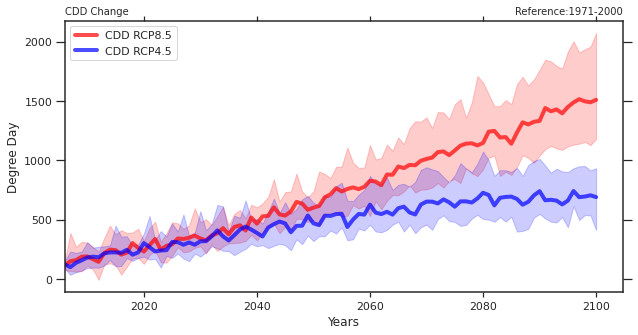

In [245]:
#Ploting
plt.rcParams["axes.linewidth"]  = 1.5
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

ax.plot(np.arange(2006,2101,1),CDD_change_rcp85['MEAN'],color='red', linewidth=4, alpha=0.7,label='CDD RCP8.5')
ax.fill_between(np.arange(2006,2101,1),CDD_change_rcp85['MAX'],CDD_change_rcp85['MIN'], alpha = 0.2, color = 'red')

ax.plot(np.arange(2006,2101,1),CDD_change_rcp45['MEAN'],color='blue', linewidth=4, alpha=0.7,label='CDD RCP4.5')
ax.fill_between(np.arange(2006,2101,1),CDD_change_rcp45['MAX'],CDD_change_rcp45['MIN'], alpha = 0.2, color = 'blue')

ax.set_title('CDD Change  ', loc='left',Fontsize=10)
ax.set_title('Reference:1971-2000',loc='right', fontsize=10)

ax.legend(loc = 'upper left')
# Set the x-axis label
ax.set_xlabel("Years");
# Set the y-axis label
ax.set_ylabel("Degree Day");
plt.xlim(xmin=2006)


plt.savefig('/mys3bucket/cdd_output/Figures/cdd_change.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/cdd_change.png')


In [246]:
CDD_anomaly_rcp85.head()

CDD_CNRM  CDD_CSIRO  CDD_GFDL  CDD_IPSL  CDD_MIROC5   CDD_MPI  CDD_NorESM1  \
0  1.768011   1.425574  1.551233  2.071768    1.075499  1.967740     1.392846   
1  0.956710   1.424602  5.481031  2.679345    0.922444  1.577241     1.778601   
2  2.203479   2.623556  0.881644  3.833094    1.519483  2.410313     2.257500   
3  0.927921   2.189821  2.183114  4.417026    3.033444  2.929674     2.869788   
4  1.947856   2.403125  2.471006  1.569208    3.857347  2.236561     4.332312   

       MEAN       MIN       MAX  
0  1.607524  1.075499  2.071768  
1  2.117139  0.922444  5.481031  
2  2.247010  0.881644  3.833094  
3  2.650113  0.927921  4.417026  
4  2.688202  1.569208  4.332312

/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if sys.path[0] == '':
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend

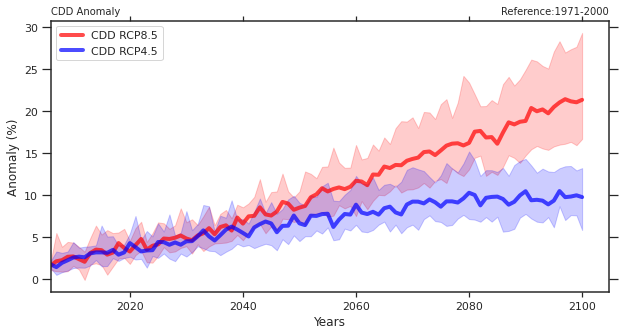

In [247]:
#Ploting
plt.rcParams["axes.linewidth"]  = 1.5
fig = plt.figure(figsize=(10,5))
ax = plt.axes()

ax.plot(np.arange(2006,2101,1),CDD_anomaly_rcp85['MEAN'],color='red', linewidth=4, alpha=0.7,label='CDD RCP8.5')
ax.fill_between(np.arange(2006,2101,1),CDD_anomaly_rcp85['MAX'],CDD_anomaly_rcp85['MIN'], alpha = 0.2, color = 'red')

ax.plot(np.arange(2006,2101,1),CDD_anomaly_rcp45['MEAN'],color='blue', linewidth=4, alpha=0.7,label='CDD RCP4.5')
ax.fill_between(np.arange(2006,2101,1),CDD_anomaly_rcp45['MAX'],CDD_anomaly_rcp45['MIN'], alpha = 0.2, color = 'blue')

ax.set_title('CDD Anomaly  ', loc='left',Fontsize=10)
ax.set_title('Reference:1971-2000',loc='right', fontsize=10)

ax.legend(loc = 'upper left')
# Set the x-axis label
ax.set_xlabel("Years");
# Set the y-axis label
ax.set_ylabel("Anomaly (%)");
plt.xlim(xmin=2006)


plt.savefig('/mys3bucket/cdd_output/Figures/cdd_anomaly.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/cdd_anomaly.png')


In [248]:
## Export files 
CDD_anomaly_rcp45.to_csv('/mys3bucket/cdd_output/CDD_anomaly_rcp45.csv')
CDD_anomaly_rcp85.to_csv('/mys3bucket/cdd_output/CDD_anomaly_rcp85.csv')

In [249]:
## Export files 
CDD_change_rcp85.to_csv('/mys3bucket/cdd_output/CDD_change_rcp85.csv')
CDD_change_rcp45.to_csv('/mys3bucket/cdd_output/CDD_change_rcp45.csv')

In [250]:
CDD_change_rcp85.tail()

CDD_CNRM    CDD_CSIRO     CDD_GFDL     CDD_IPSL   CDD_MIROC5  \
90  1131.592665  2002.676127  1439.014800  1696.315541  1308.161556   
91  1234.771983  1905.169824  1139.358463  1907.563810  1471.187249   
92  1154.891662  1684.655237  1300.332375  1935.051046  1623.351284   
93  1175.733797  1894.026782  1361.773348  1955.927031  1282.676737   
94  1180.232416  2073.163759  1185.184159  1874.625390          NaN   

        CDD_MPI  CDD_NorESM1         MEAN          MIN          MAX  
90  1568.138165  1262.346080  1486.892133  1131.592665  2002.676127  
91  1708.404043  1235.995830  1514.635886  1139.358463  1907.563810  
92  1592.590446  1184.542442  1496.487785  1154.891662  1935.051046  
93  1621.305936  1127.272789  1488.388060  1127.272789  1955.927031  
94  1563.105110  1180.090579  1509.400235  1180.090579  2073.163759

In [251]:
# # convert into standard CRS 
# all_files.rio.write_crs("epsg:4326", inplace=True)

# temp_country = {}
# small_countries = []
# for i in range(states_gdf.shape[0]):
#     data = states_gdf[states_gdf.index==i]
#     try:
#         clip = all_files.rio.clip(data.geometry.apply(mapping), data.crs).mean(dim=['lon','lat'])
#         temp_country[states_gdf.iloc[i]['NAME']] = clip
        
#     except:
#         small_countries.append(states_gdf.iloc[i]['NAME'])


# dd=pd.DataFrame()
# for key in temp_country.keys():
#     tmp=temp_country[key]
#     tmp2=tmp.expand_dims("Country").to_dataframe().reset_index().drop(columns='spatial_ref')
#     tmp2['Country']=str(key)
    
#     dd=dd.append(tmp2)

In [252]:
## To be done

In [253]:
# ## Model evaluation 

# 0- Historical CDD of uncorrected Model
# 0- Historical CDD over validation period
# 1- Changes of Observed CDD  (a) and the difference between the model simulations and observations over wEST aFRICA (1976-2000 mean)
# 2- Changes of Observed CDD OVER GWL 
# 3- Changes of CDD with weighted population under GWL
# 4- Changes of CDD with weighted population under GWL BY COUNTRY

## Task 0- Historical CDD of uncorrected Model

In [254]:
# import land mask
mask=xr.open_dataset('/mys3bucket/ERA_Temp/mask_new.nc')['region']

In [255]:
from glob import glob
# ds = xr.merge([xr.open_dataset(f) for f in glob('/mys3bucket/Historical_cdd/MMM_CDD_tas_*.nc')])

In [256]:
glob('/mys3bucket/Historical_cdd/CLIM_CDD_tas_*.nc')

['/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_CNRM-CM5_1971_2000_WAfrik.nc',
 '/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_CSIRO-Mk3-6-0_1971_2000_WAfrik.nc',
 '/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_GFDL-ESM2M__1971_2000_WAfrik.nc',
 '/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_IPSL-CM5A-MR_1971_2000_WAfrik.nc',
 '/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_MIROC5_1971_2000_WAfrik.nc',
 '/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_MPI-ESM-LR_1971_2000_WAfrik.nc',
 '/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_NorESM1-M_1971_2000_WAfrik.nc']

In [257]:
obs=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_Daily_air_temperature_at_2_metres_1970_2000_WA.nc')
mm_model=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_MMM_CDD_tas_day_BCSD_historical_r1i1p1_1971_2000.nc')

In [258]:
Cnrm=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_CNRM-CM5_1971_2000_WAfrik.nc')
csiro=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_CSIRO-Mk3-6-0_1971_2000_WAfrik.nc')
gfdl=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_GFDL-ESM2M__1971_2000_WAfrik.nc')
ipsl=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_IPSL-CM5A-MR_1971_2000_WAfrik.nc')
miroc=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_MIROC5_1971_2000_WAfrik.nc')
mpi=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_MPI-ESM-LR_1971_2000_WAfrik.nc')
nor=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_NorESM1-M_1971_2000_WAfrik.nc')

In [259]:
all_base=obs.rename({'cooling_degree_days':'CDD_OBS'})

In [260]:
all_base['CDD_MME']=mm_model.cooling_degree_days.mean('time')
all_base['CDD_CNRM']=Cnrm.cooling_degree_days.mean('time')
all_base['CDD_CSIRO']=csiro.cooling_degree_days.mean('time')
all_base['CDD_GFDL']=gfdl.cooling_degree_days.mean('time')
all_base['CDD_IPSL']=ipsl.cooling_degree_days.mean('time')
all_base['CDD_MIROC5']=miroc.cooling_degree_days.mean('time')
all_base['CDD_MPI']=mpi.cooling_degree_days.mean('time')
all_base['CDD_NorESM1']=nor.cooling_degree_days.mean('time')

In [261]:
all_base_masked=all_base.where(mask)

In [262]:
longitude=all_base.CDD_OBS.lon.values 
latitude=all_base.CDD_OBS.lat.values 

In [263]:
order_plot=['CDD_OBS','CDD_MME','CDD_CNRM','CDD_CSIRO','CDD_GFDL','CDD_IPSL','CDD_MIROC5','CDD_MPI','CDD_NorESM1']

In [264]:
# Libraries below are essential to perform statistical metrics

In [265]:
import metpy.calc as mpcalc
from metpy.units import units
import xskillscore as xs

In [266]:
all_base_masked

<xarray.Dataset>
Dimensions:      (lat: 121, lon: 181)
Coordinates:
  * lon          (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.5 24.75 25.0
  * lat          (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 0.75 0.5 0.25 0.0
Data variables:
    CDD_OBS      (lat, lon) float32 nan nan nan nan ... 42.45 32.06 31.88 32.04
    CDD_MME      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_CNRM     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_CSIRO    (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_GFDL     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_IPSL     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_MIROC5   (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_MPI      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_NorESM1  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

## Climatological mean CDD per model

<function matplotlib.pyplot.show>

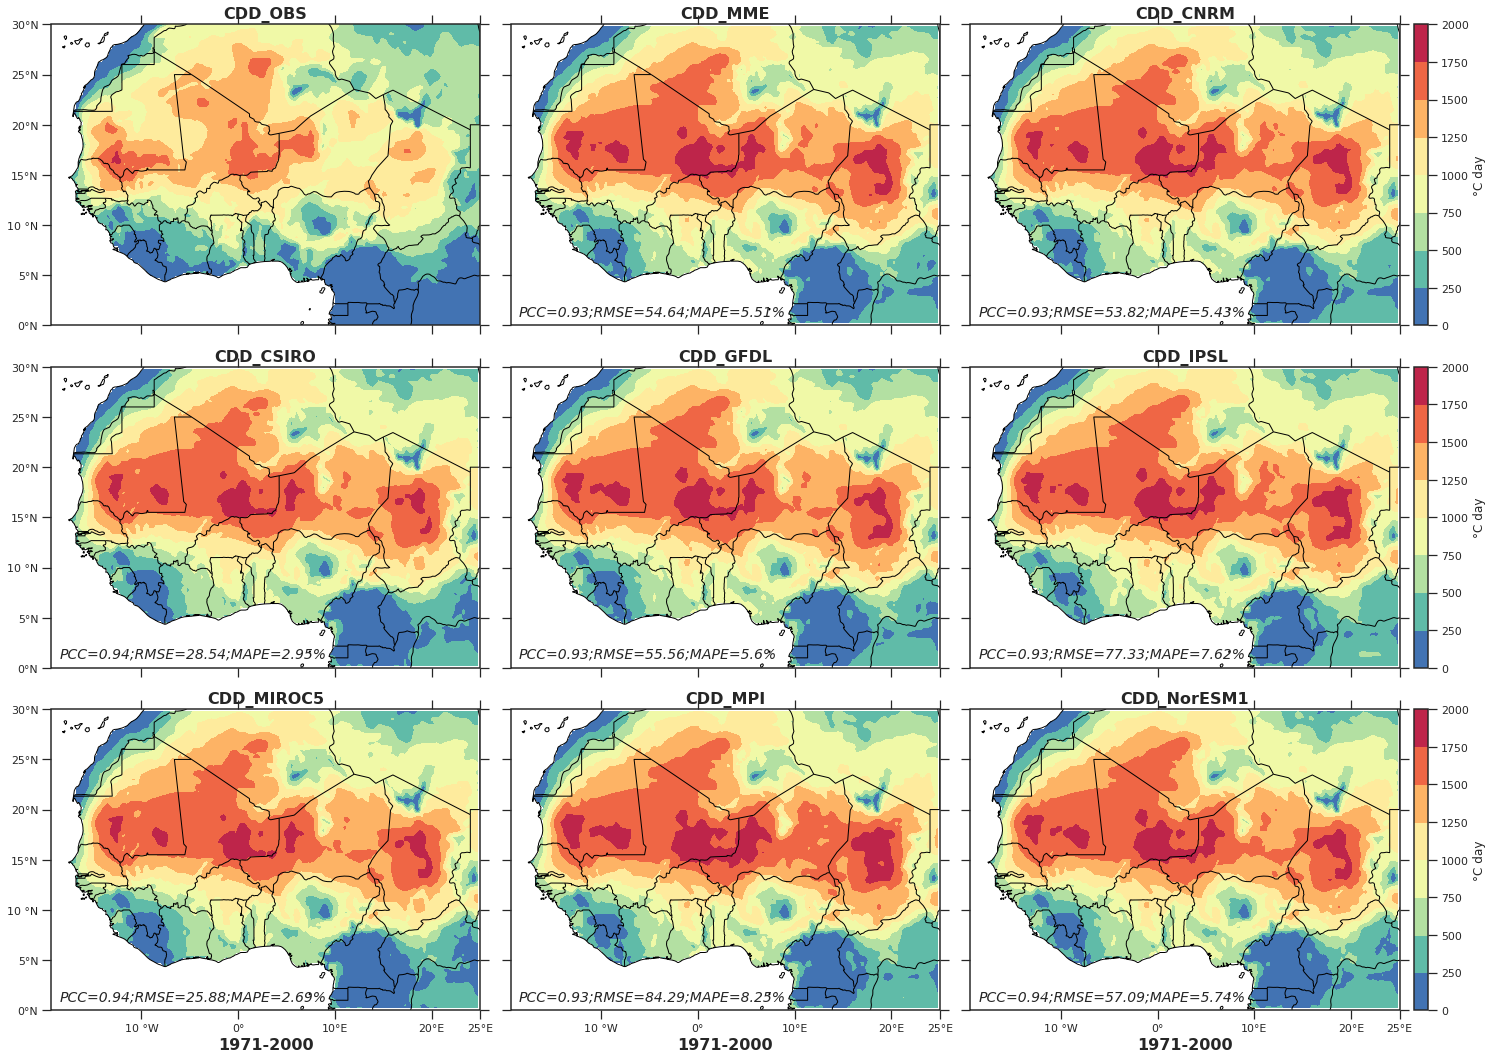

In [267]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =16
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=9
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}E',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()


fig, axes = plt.subplots(3,3,sharex=True, sharey=True,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,15)

for i in range(3):
    
    o= axes[0,i].contourf(longitude, latitude,all_base_masked[str(order_plot[i])],
                          transform=projection,cmap='Spectral_r')
    p= axes[1,i].contourf(longitude, latitude,all_base_masked[str(order_plot[i+3])],
                          transform=projection,cmap='Spectral_r')
    
    q= axes[2,i].contourf(longitude, latitude,all_base_masked[str(order_plot[i+6])],
                          transform=projection,cmap='Spectral_r')
    
    axes[0, i].set_title(order_plot[i],fontsize=16,fontweight='bold')
    axes[1, i].set_title(order_plot[i+3],fontsize=16,fontweight='bold')
    axes[2, i].set_title(order_plot[i+6],fontsize=16,fontweight='bold')
    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
#     ax.axes.axis('tight')

for i,model in enumerate(('CDD_MME','CDD_CNRM')):
    axes[0,i+1].text(-18.5,1,
             str('PCC='+str(round(xr.corr(all_base_masked[str(model)],all_base_masked['CDD_OBS']).mean().values*1,2))+';RMSE='+
                 str(round(xs.rmse(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*1,2))+';MAPE='+
                 str(round(xs.mape(all_base_masked[str(model)].mean(['lon','lat']),
                                   all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*100,2))+'%'),
             fontsize=14, ha='left',fontstyle='italic')

for i,model in enumerate(('CDD_CSIRO','CDD_GFDL','CDD_IPSL')):
    axes[1,i].text(-18.5,1,
             str('PCC='+str(round(xr.corr(all_base_masked[str(model)],all_base_masked['CDD_OBS']).mean().values*1,2))+';RMSE='+
                 str(round(xs.rmse(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*1,2))+';MAPE='+
                 str(round(xs.mape(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*100,2))+'%'),
             fontsize=14, ha='left',fontstyle='italic')

for i,model in enumerate(('CDD_MIROC5','CDD_MPI','CDD_NorESM1')):
    axes[2,i].text(-18.5,1,
             str('PCC='+str(round(xr.corr(all_base_masked[str(model)],all_base_masked['CDD_OBS']).mean().values*1,2))+';RMSE='+
                 str(round(xs.rmse(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*1,2))+';MAPE='+
                 str(round(xs.mape(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*100,2))+'%'),
             fontsize=14, ha='left',fontstyle='italic')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels)
    ax.axes.axis('tight')
    
    
    

for ax in axes[-1,:].flatten():
    ax.set_xlabel('1971-2000',fontsize=16,fontweight='bold')

plt.tight_layout()

# flatten axes and get subplots positions
DP = axes.T.flatten()

# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[6].get_position().x1+0.01,DP[6].get_position().y0,
                 0.01,DP[6].get_position().height])
cax2=fig.add_axes([DP[7].get_position().x1+0.01,DP[7].get_position().y0,
                 0.01,DP[7].get_position().height])
cax3=fig.add_axes([DP[8].get_position().x1+0.01,DP[8].get_position().y0,
                 0.01,DP[8].get_position().height])


# plot colobar on figures
fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='\N{DEGREE SIGN}C day')


plt.savefig('/mys3bucket/cdd_output/Figures/CDD_HIST.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_HIST.png',transparent=True,dpi=300)
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_HIST.svg',transparent=True,dpi=1200)



plt.show

In [268]:
all_base_masked.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/CDD_finalhist_model.csv')
all_base_masked.to_dataframe().describe()

CDD_OBS       CDD_MME      CDD_CNRM     CDD_CSIRO      CDD_GFDL  \
count  17205.000000  16884.000000  16884.000000  16884.000000  16884.000000   
mean     937.300781    991.944824    991.119690    965.833862    992.859192   
std      531.057251    495.200867    493.009369    495.839386    496.097870   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      522.139587    612.490906    613.105530    582.047241    612.368164   
50%      966.490173   1000.593994    998.945557    974.771484   1003.190918   
75%     1368.830811   1439.451660   1437.702148   1414.544189   1435.261475   
max     2184.953613   1948.441895   1946.037598   1922.808228   1947.134888   

           CDD_IPSL    CDD_MIROC5       CDD_MPI   CDD_NorESM1  
count  16884.000000  16884.000000  16884.000000  16884.000000  
mean    1014.632446    963.179504   1021.583862    994.389343  
std      485.822449    495.403809    501.539307    499.764984  
min        0.000000      0.000000      0.000000      0.000000  
25%      647.337830    579.808228    638.041443    613.507935  
50%     1023.878662    974.187439   1028.664917   1003.716614  
75%     1455.168579   1410.804077   1477.584351   1444.232178  
max     1950.697144   1919.089600   1994.481689   1958.844116

In [269]:
all_base_masked

<xarray.Dataset>
Dimensions:      (lat: 121, lon: 181)
Coordinates:
  * lon          (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.5 24.75 25.0
  * lat          (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 0.75 0.5 0.25 0.0
Data variables:
    CDD_OBS      (lat, lon) float32 nan nan nan nan ... 42.45 32.06 31.88 32.04
    CDD_MME      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_CNRM     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_CSIRO    (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_GFDL     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_IPSL     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_MIROC5   (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_MPI      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDD_NorESM1  (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan

# Task 2- Changes of Observed CDD OVER GWL 

In [270]:
# Cnrm_df=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_CNRM-CM5_1971_2000_WAfrik.nc')
# csiro_df=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_CSIRO-Mk3-6-0_1971_2000_WAfrik.nc')
# gfdl_df=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_GFDL-ESM2M__1971_2000_WAfrik.nc')
# ipsl=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_IPSL-CM5A-MR_1971_2000_WAfrik.nc')
# miroc=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_MIROC5_1971_2000_WAfrik.nc')
# mpi=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_MPI-ESM-LR_1971_2000_WAfrik.nc')
# nor=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_tas_day_BCSD_historical_r1i1p1_NorESM1-M_1971_2000_WAfrik.nc')

In [271]:
mm_model=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_MMM_CDD_tas_day_BCSD_historical_r1i1p1_1971_2000.nc')

In [272]:
cdd_gwl=xr.open_mfdataset('CLIM*.nc')

In [273]:
cdd_gwl_model=xr.open_mfdataset('CDD_GWL_*_tas_BCSD_rcp85_r1i1p1_CNRM-CM5_2015_2044_WAfrik_rg_Bias-eqm.nc')

In [274]:
cdd_model=xr.open_dataset('CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_CNRM-CM5_2015_2044_WAfrik_rg_Bias-eqm.nc').mean('time')

In [275]:
cdd_final=cdd_model

In [276]:
cdd_final

<xarray.Dataset>
Dimensions:              (lat: 121, lon: 181)
Coordinates:
  * lon                  (lon) float32 -20.0 -19.75 -19.5 ... 24.5 24.75 25.0
  * lat                  (lat) float32 30.0 29.75 29.5 29.25 ... 0.5 0.25 0.0
Data variables:
    cooling_degree_days  (lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [277]:
all=glob('CDD_GWL_*.nc')

In [278]:
all

['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_CNRM-CM5_2015_2044_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_CSIRO-Mk3-6-0_2018_2047_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_GFDL-ESM2M_2020_2049_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_IPSL-CM5A-MR_2002_2031_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_MIROC5_2019_2048_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_MPI-ESM-LR_2004_2033_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_NorESM1-M_2019_2048_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_CNRM-CM5_2029_2058_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_CSIRO-Mk3-6-0_2030_2059_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_GFDL-ESM2M_2037_2069_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_IPSL-CM5A-MR_2016_2045_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_MIROC5_2034_2063_WAfrik_rg_Bias-eqm.nc',
 'CDD_GWL_2.0_tas_BCSD_rcp85_r1

In [279]:
## Combine files together by gwls
GWL_NAME=['1.5','2.0','2.5','3.0'] # Models prefix labels
NEX_name=['CNRM-CM5','CSIRO-Mk3-6-0','GFDL-ESM2M','IPSL-CM5A-MR','MIROC5','MPI-ESM-LR','NorESM1-M'] # Models prefix labels

i=0
for gwl in (GWL_NAME):
    print(gwl)
    for model in (NEX_name):
        model_dt=glob('CDD_GWL_'+gwl+'_tas_BCSD_rcp85_r1i1p1_'+str(model)+'_*.nc')
        print(model_dt)
        if i<=0:
            i=i+1
#             print('1st opening')
            cdd_model=xr.open_dataset(model_dt[0]).mean('time')
            cdd_final=cdd_model.rename({'cooling_degree_days':str('CDD_'+gwl+'_'+model)})
        if i > 0 :
#             print('2nd opening')
#             print(str('CDD_'+model))
            tmp=xr.open_dataset(model_dt[0]).mean('time')
            cdd_final[str('CDD_'+gwl+'_'+model)]=tmp.cooling_degree_days

cdd_final

1.5
['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_CNRM-CM5_2015_2044_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_CSIRO-Mk3-6-0_2018_2047_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_GFDL-ESM2M_2020_2049_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_IPSL-CM5A-MR_2002_2031_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_MIROC5_2019_2048_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_MPI-ESM-LR_2004_2033_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_NorESM1-M_2019_2048_WAfrik_rg_Bias-eqm.nc']
2.0
['CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_CNRM-CM5_2029_2058_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_CSIRO-Mk3-6-0_2030_2059_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_GFDL-ESM2M_2037_2069_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_IPSL-CM5A-MR_2016_2045_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_MIROC5_2034_2063_WAfrik_rg_Bias-eqm.nc']
['CDD_GWL_2.0_tas_BCSD_

<xarray.Dataset>
Dimensions:                (lat: 121, lon: 181)
Coordinates:
  * lon                    (lon) float32 -20.0 -19.75 -19.5 ... 24.5 24.75 25.0
  * lat                    (lat) float32 30.0 29.75 29.5 29.25 ... 0.5 0.25 0.0
Data variables:
    CDD_1.5_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan

In [280]:
 cdd_final

<xarray.Dataset>
Dimensions:                (lat: 121, lon: 181)
Coordinates:
  * lon                    (lon) float32 -20.0 -19.75 -19.5 ... 24.5 24.75 25.0
  * lat                    (lat) float32 30.0 29.75 29.5 29.25 ... 0.5 0.25 0.0
Data variables:
    CDD_1.5_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan

In [281]:
GWL_NAME=['1.5','2.0','2.5','3.0'] # Models prefix labels
NEX_name=['CNRM-CM5','CSIRO-Mk3-6-0','GFDL-ESM2M','IPSL-CM5A-MR','MIROC5','MPI-ESM-LR','NorESM1-M'] # Models prefix labels

In [282]:
## Create a masked file
cdd_final=cdd_final.where(mask)

# Plot CDD by models and global warming level

<function matplotlib.pyplot.show>

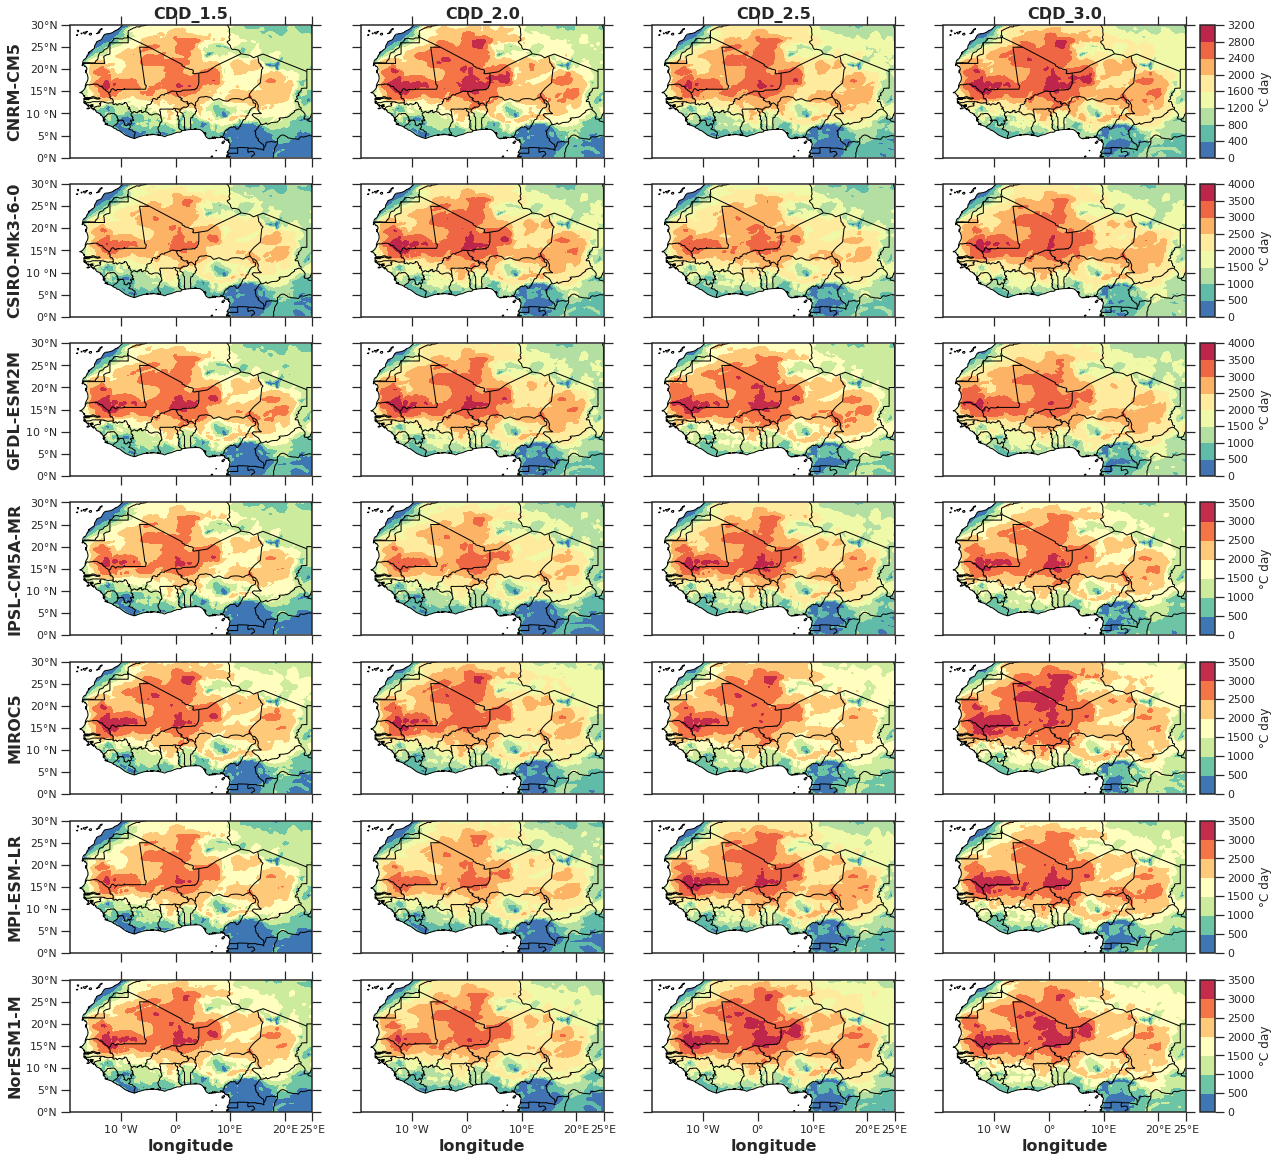

In [283]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =12
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=9
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}E',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()


fig, axes = plt.subplots(7,4,sharex=True, sharey=True,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,20)

# NEX_name=['CNRM-CM5','CSIRO-Mk3-6-0','GFDL-ESM2M','IPSL-CM5A-MR','MIROC5','MPI-ESM-LR','NorESM1-M'] # Models prefix labels

for i, gwl in enumerate(GWL_NAME):
    
    o= axes[0,i].contourf(longitude, latitude,cdd_final[str('CDD_'+gwl+'_CNRM-CM5')],
                          transform=projection,cmap='Spectral_r')
    p= axes[1,i].contourf(longitude, latitude,cdd_final[str('CDD_'+gwl+'_CSIRO-Mk3-6-0')],
                          transform=projection,cmap='Spectral_r')
    q= axes[2,i].contourf(longitude, latitude,cdd_final[str('CDD_'+gwl+'_GFDL-ESM2M')],
                          transform=projection,cmap='Spectral_r')   
    r= axes[3,i].contourf(longitude, latitude,cdd_final[str('CDD_'+gwl+'_IPSL-CM5A-MR')],
                          transform=projection,cmap='Spectral_r')
    s= axes[4,i].contourf(longitude, latitude,cdd_final[str('CDD_'+gwl+'_MIROC5')],
                          transform=projection,cmap='Spectral_r') 
    t= axes[5,i].contourf(longitude, latitude,cdd_final[str('CDD_'+gwl+'_MPI-ESM-LR')],
                          transform=projection,cmap='Spectral_r')
    u= axes[6,i].contourf(longitude, latitude,cdd_final[str('CDD_'+gwl+'_NorESM1-M')],
                          transform=projection,cmap='Spectral_r') 

    axes[0, i].set_title(str('CDD_'+gwl),fontsize=16,fontweight='bold')

# Assign label to y axis
for i,rowlabel in enumerate(NEX_name):
    axes[i, 0].set_ylabel(rowlabel,fontsize=16,fontweight='bold')
    
    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
#     ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels)
    ax.axes.axis('tight')
    
    

for ax in axes[-1,:].flatten():
    ax.set_xlabel('longitude',fontsize=16,fontweight='bold')



# flatten axes and get subplots positions
DP = axes.T.flatten()

# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[21].get_position().x1+0.01,DP[21].get_position().y0,
                 0.01,DP[21].get_position().height])
cax2=fig.add_axes([DP[22].get_position().x1+0.01,DP[22].get_position().y0,
                 0.01,DP[22].get_position().height])
cax3=fig.add_axes([DP[23].get_position().x1+0.01,DP[23].get_position().y0,
                 0.01,DP[23].get_position().height])
cax4=fig.add_axes([DP[24].get_position().x1+0.01,DP[24].get_position().y0,
                 0.01,DP[24].get_position().height])
cax5=fig.add_axes([DP[25].get_position().x1+0.01,DP[25].get_position().y0,
                 0.01,DP[25].get_position().height])
cax6=fig.add_axes([DP[26].get_position().x1+0.01,DP[26].get_position().y0,
                 0.01,DP[26].get_position().height])
cax7=fig.add_axes([DP[27].get_position().x1+0.01,DP[27].get_position().y0,
                 0.01,DP[27].get_position().height])

# plt.tight_layout()

# plot colobar on figures
fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='\N{DEGREE SIGN}C day')
fig.colorbar(r, cax=cax4,label='\N{DEGREE SIGN}C day')
fig.colorbar(s, cax=cax5,label='\N{DEGREE SIGN}C day')
fig.colorbar(t, cax=cax6,label='\N{DEGREE SIGN}C day')
fig.colorbar(u, cax=cax7,label='\N{DEGREE SIGN}C day')
# fig.colorbar(vars, cax=cax2,label='C day')



plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl.png',transparent=True,dpi=300)



plt.show

In [284]:
cdd_final.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/CDD_final_gwl_models.csv')
cdd_final.to_dataframe().describe()

CDD_1.5_CNRM-CM5  CDD_1.5_CSIRO-Mk3-6-0  CDD_1.5_GFDL-ESM2M  \
count      16884.000000           16884.000000        16884.000000   
mean        1246.854971            1417.926315         1360.591887   
std          605.891245             632.350404          625.172778   
min            0.015848               0.000000            0.000000   
25%          805.833972             954.121727          882.741284   
50%         1324.419554            1493.596812         1434.993477   
75%         1728.116408            1928.904614         1878.075666   
max         2583.788985            2823.345725         2736.235073   

       CDD_1.5_IPSL-CM5A-MR  CDD_1.5_MIROC5  CDD_1.5_MPI-ESM-LR  \
count          16884.000000    16884.000000        16884.000000   
mean            1254.683328     1414.253405         1250.414272   
std              614.628211      614.053816          614.584670   
min                0.000000        0.048628            0.000000   
25%              806.581956      992.062975          800.390482   
50%             1315.737083     1497.465569         1323.344567   
75%             1735.496118     1882.300982         1746.863205   
max             2610.099368     2752.663025         2557.507274   

       CDD_1.5_NorESM1-M  CDD_2.0_CNRM-CM5  CDD_2.0_CSIRO-Mk3-6-0  \
count       16884.000000      16884.000000           16884.000000   
mean         1353.077400       1423.708418            1644.817393   
std           632.171130        646.873673             691.173344   
min             0.005114          0.012993               0.029653   
25%           919.626214        958.583781            1120.017717   
50%          1423.921069       1509.303891            1714.362694   
75%          1843.968471       1934.770859            2210.796938   
max          2685.319497       2799.580277            3163.080545   

       CDD_2.0_GFDL-ESM2M  ...  CDD_2.5_MIROC5  CDD_2.5_MPI-ESM-LR  \
count        16884.000000  ...    16884.000000        16884.000000   
mean          1628.994378  ...     1847.893736         1652.812271   
std            679.645199  ...      685.392661          688.231048   
min              0.018052  ...        0.109305            0.000000   
25%           1103.968093  ...     1390.730517         1164.472751   
50%           1697.045430  ...     1921.703887         1748.401320   
75%           2192.917957  ...     2358.930838         2197.773292   
max           3115.576154  ...     3291.148837         3102.143387   

       CDD_2.5_NorESM1-M  CDD_3.0_CNRM-CM5  CDD_3.0_CSIRO-Mk3-6-0  \
count       16884.000000      16884.000000           16884.000000   
mean         1744.880520       1746.613936            2087.674091   
std           691.062716        686.553080             775.411401   
min             0.154700          0.002986               0.034666   
25%          1298.180985       1264.156175            1483.335521   
50%          1829.714464       1839.004759            2158.296472   
75%          2266.559818       2285.315947            2711.713115   
max          3128.197099       3145.604144            3793.601308   

       CDD_3.0_GFDL-ESM2M  CDD_3.0_IPSL-CM5A-MR  CDD_3.0_MIROC5  \
count        16884.000000          16884.000000    16884.000000   
mean          2062.552810           1795.565652     2009.464204   
std            746.226880            703.000662      703.819991   
min              0.653706              0.033022        0.187622   
25%           1467.270085           1276.912882     1552.006108   
50%           2119.146014           1877.536293     2066.246202   
75%           2673.751736           2340.832951     2531.876124   
max           3684.485104           3280.978940     3495.338519   

       CDD_3.0_MPI-ESM-LR  CDD_3.0_NorESM1-M  
count        16884.000000       16884.000000  
mean          1873.167574        1927.464466  
std            728.968288         713.385407  
min              0.000000           0.276515  
25%           1357.529719        1461.282154  
50%        

In [285]:
## check summary of files

In [286]:
cdd_final.to_dataframe().describe(percentiles=[.1, .25, .5, .75, .9,.95])

CDD_1.5_CNRM-CM5  CDD_1.5_CSIRO-Mk3-6-0  CDD_1.5_GFDL-ESM2M  \
count      16884.000000           16884.000000        16884.000000   
mean        1246.854971            1417.926315         1360.591887   
std          605.891245             632.350404          625.172778   
min            0.015848               0.000000            0.000000   
10%          323.331196             494.023976          465.704625   
25%          805.833972             954.121727          882.741284   
50%         1324.419554            1493.596812         1434.993477   
75%         1728.116408            1928.904614         1878.075666   
90%         2012.770953            2218.096390         2138.950895   
95%         2133.496050            2332.048641         2263.068473   
max         2583.788985            2823.345725         2736.235073   

       CDD_1.5_IPSL-CM5A-MR  CDD_1.5_MIROC5  CDD_1.5_MPI-ESM-LR  \
count          16884.000000    16884.000000        16884.000000   
mean            1254.683328     1414.253405         1250.414272   
std              614.628211      614.053816          614.584670   
min                0.000000        0.048628            0.000000   
10%              324.242322      487.837031          323.085533   
25%              806.581956      992.062975          800.390482   
50%             1315.737083     1497.465569         1323.344567   
75%             1735.496118     1882.300982         1746.863205   
90%             2048.377431     2193.093299         2033.890305   
95%             2175.414831     2298.916205         2148.574307   
max             2610.099368     2752.663025         2557.507274   

       CDD_1.5_NorESM1-M  CDD_2.0_CNRM-CM5  CDD_2.0_CSIRO-Mk3-6-0  \
count       16884.000000      16884.000000           16884.000000   
mean         1353.077400       1423.708418            1644.817393   
std           632.171130        646.873673             691.173344   
min             0.005114          0.012993               0.029653   
10%           375.883736        448.460291             673.988457   
25%           919.626214        958.583781            1120.017717   
50%          1423.921069       1509.303891            1714.362694   
75%          1843.968471       1934.770859            2210.796938   
90%          2156.439130       2243.225090            2525.128981   
95%          2288.326376       2361.184755            2654.627820   
max          2685.319497       2799.580277            3163.080545   

       CDD_2.0_GFDL-ESM2M  ...  CDD_2.5_MIROC5  CDD_2.5_MPI-ESM-LR  \
count        16884.000000  ...    16884.000000        16884.000000   
mean          1628.994378  ...     1847.893736         1652.812271   
std            679.645199  ...      685.392661          688.231048   
min              0.018052  ...        0.109305            0.000000   
10%            695.945034  ...      854.280671          632.878965   
25%           1103.968093  ...     1390.730517         1164.472751   
50%           1697.045430  ...     1921.703887         1748.401320   
75%           2192.917957  ...     2358.930838         2197.773292   
90%           2494.645431  ...     2727.769398         2514.412101   
95%           2611.857423  ...     2854.042876         2629.805695   
max           3115.576154  ...     3291.148837         3102.143387   

       CDD_2.5_NorESM1-M  CDD_3.0_CNRM-CM5  CDD_3.0_CSIRO-Mk3-6-0  \
count       16884.000000      16884.000000           16884.000000   
mean         1744.880520       1746.613936            2087.674091   
std           691.062716        686.553080             775.411401   
min             0.154700          0.002986               0.034666   
10%           703.185368        734.554105            1055.547513   
25%          1298.180985       1264.156175            1483.335521   
50%          1829.714464       1839.004759            2158.296472   
75%          2266.559818       2285.315947            2711.713115   
90%          2624.479571       2608.176839            3091.792699   
9

In [287]:
### Compute CDD Change

In [288]:
obs_clim=xr.open_dataset('/mys3bucket/Historical_cdd/CLIM_CDD_Daily_air_temperature_at_2_metres_1970_2000_WA.nc').cooling_degree_days
obs_clim=obs_clim.where(mask)

In [289]:
cdd_change=cdd_final-obs_clim

In [290]:
cdd_change

<xarray.Dataset>
Dimensions:                (lat: 121, lon: 181)
Coordinates:
  * lon                    (lon) float32 -20.0 -19.75 -19.5 ... 24.5 24.75 25.0
  * lat                    (lat) float32 30.0 29.75 29.5 29.25 ... 0.5 0.25 0.0
Data variables:
    CDD_1.5_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_1.5_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.0_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_2.5_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_CNRM-CM5       (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_CSIRO-Mk3-6-0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_GFDL-ESM2M     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_IPSL-CM5A-MR   (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_MIROC5         (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_MPI-ESM-LR     (lat, lon) float64 nan nan nan nan ... nan nan nan
    CDD_3.0_NorESM1-M      (lat, lon) float64 nan nan nan nan ... nan nan nan

In [291]:
# MME_CDD

## Plot CDD change per Global warming change per model

<function matplotlib.pyplot.show>

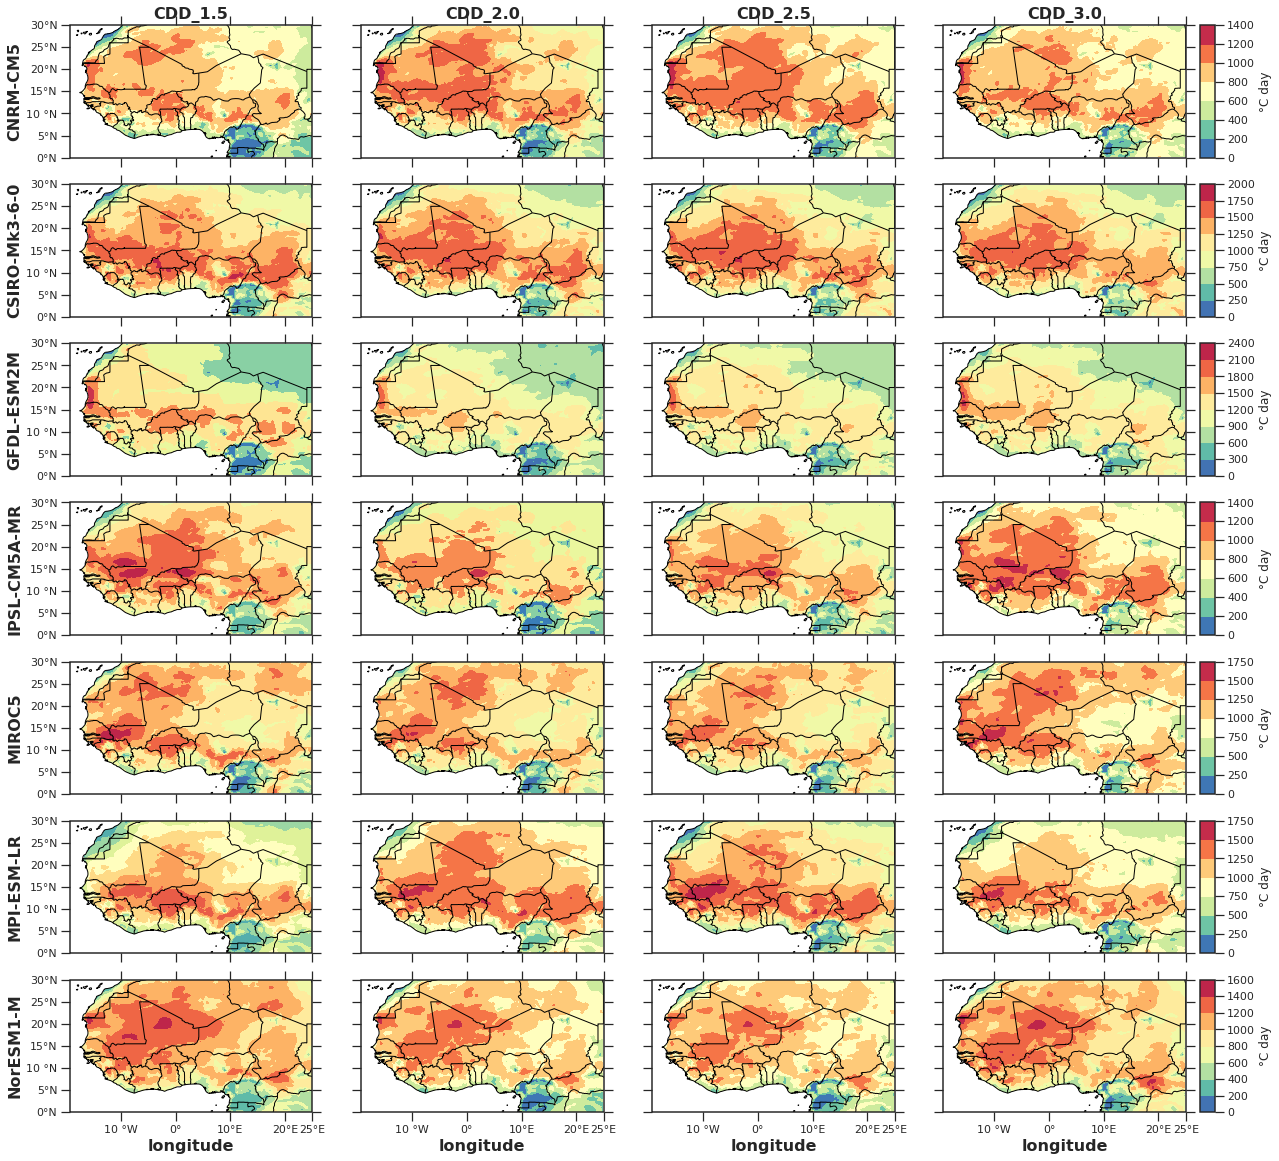

In [292]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =12
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=9
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}E',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()


fig, axes = plt.subplots(7,4,sharex=True, sharey=True,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,20)

# NEX_name=['CNRM-CM5','CSIRO-Mk3-6-0','GFDL-ESM2M','IPSL-CM5A-MR','MIROC5','MPI-ESM-LR','NorESM1-M'] # Models prefix labels

for i, gwl in enumerate(GWL_NAME):
    
    o= axes[0,i].contourf(longitude, latitude,cdd_change[str('CDD_'+gwl+'_CNRM-CM5')],
                          transform=projection,cmap='Spectral_r')
    p= axes[1,i].contourf(longitude, latitude,cdd_change[str('CDD_'+gwl+'_CSIRO-Mk3-6-0')],
                          transform=projection,cmap='Spectral_r')
    q= axes[2,i].contourf(longitude, latitude,cdd_change[str('CDD_'+gwl+'_GFDL-ESM2M')],
                          transform=projection,cmap='Spectral_r')   
    r= axes[3,i].contourf(longitude, latitude,cdd_change[str('CDD_'+gwl+'_IPSL-CM5A-MR')],
                          transform=projection,cmap='Spectral_r')
    s= axes[4,i].contourf(longitude, latitude,cdd_change[str('CDD_'+gwl+'_MIROC5')],
                          transform=projection,cmap='Spectral_r') 
    t= axes[5,i].contourf(longitude, latitude,cdd_change[str('CDD_'+gwl+'_MPI-ESM-LR')],
                          transform=projection,cmap='Spectral_r')
    u= axes[6,i].contourf(longitude, latitude,cdd_change[str('CDD_'+gwl+'_NorESM1-M')],
                          transform=projection,cmap='Spectral_r') 

    axes[0, i].set_title(str('CDD_'+gwl),fontsize=16,fontweight='bold')

# Assign label to y axis
for i,rowlabel in enumerate(NEX_name):
    axes[i, 0].set_ylabel(rowlabel,fontsize=16,fontweight='bold')
    
    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
#     ax.axes.axis('tight')

# for i,model in enumerate(('CDD_MME','CDD_CNRM')):
#     axes[0,i+1].text(-18.5,1,
#              str('PCC='+str(round(xr.corr(all_base_masked[str(model)],all_base_masked['CDD_OBS']).mean().values*1,2))+';RMSE='+
#                  str(round(xs.rmse(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*1,2))+';RBIAS='+
#                  str(round(xs.mape(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*100,2))+'%'),
#              fontsize=14, ha='left',fontstyle='italic')

# for i,model in enumerate(('CDD_CSIRO','CDD_GFDL','CDD_IPSL')):
#     axes[1,i].text(-18.5,1,
#              str('PCC='+str(round(xr.corr(all_base_masked[str(model)],all_base_masked['CDD_OBS']).mean().values*1,2))+';RMSE='+
#                  str(round(xs.rmse(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*1,2))+';RBIAS='+
#                  str(round(xs.mape(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*100,2))+'%'),
#              fontsize=14, ha='left',fontstyle='italic')

# for i,model in enumerate(('CDD_MIROC5','CDD_MPI','CDD_NorESM1')):
#     axes[2,i].text(-18.5,1,
#              str('PCC='+str(round(xr.corr(all_base_masked[str(model)],all_base_masked['CDD_OBS']).mean().values*1,2))+';RMSE='+
#                  str(round(xs.rmse(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*1,2))+';RBIAS='+
#                  str(round(xs.mape(all_base_masked[str(model)].mean(['lon','lat']),all_base_masked['CDD_OBS'].mean(['lon','lat'])).values*100,2))+'%'),
#              fontsize=14, ha='left',fontstyle='italic')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels)
    ax.axes.axis('tight')
    
    

for ax in axes[-1,:].flatten():
    ax.set_xlabel('longitude',fontsize=16,fontweight='bold')



# flatten axes and get subplots positions
DP = axes.T.flatten()

# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[21].get_position().x1+0.01,DP[21].get_position().y0,
                 0.01,DP[21].get_position().height])
cax2=fig.add_axes([DP[22].get_position().x1+0.01,DP[22].get_position().y0,
                 0.01,DP[22].get_position().height])
cax3=fig.add_axes([DP[23].get_position().x1+0.01,DP[23].get_position().y0,
                 0.01,DP[23].get_position().height])
cax4=fig.add_axes([DP[24].get_position().x1+0.01,DP[24].get_position().y0,
                 0.01,DP[24].get_position().height])
cax5=fig.add_axes([DP[25].get_position().x1+0.01,DP[25].get_position().y0,
                 0.01,DP[25].get_position().height])
cax6=fig.add_axes([DP[26].get_position().x1+0.01,DP[26].get_position().y0,
                 0.01,DP[26].get_position().height])
cax7=fig.add_axes([DP[27].get_position().x1+0.01,DP[27].get_position().y0,
                 0.01,DP[27].get_position().height])

# plt.tight_layout()

# plot colobar on figures
fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='\N{DEGREE SIGN}C day')
fig.colorbar(r, cax=cax4,label='\N{DEGREE SIGN}C day')
fig.colorbar(s, cax=cax5,label='\N{DEGREE SIGN}C day')
fig.colorbar(t, cax=cax6,label='\N{DEGREE SIGN}C day')
fig.colorbar(u, cax=cax7,label='\N{DEGREE SIGN}C day')
# fig.colorbar(vars, cax=cax2,label='C day')



plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change.png',transparent=True,dpi=300)



plt.show

In [293]:
cdd_change.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/Figures/CDD_final_change_gwl_models.csv')
cdd_change.to_dataframe().describe()

CDD_1.5_CNRM-CM5  CDD_1.5_CSIRO-Mk3-6-0  CDD_1.5_GFDL-ESM2M  \
count      16884.000000           16884.000000        16884.000000   
mean         301.486830             472.558174          415.223746   
std           90.909405             135.767947          150.549064   
min            0.015848               0.000000            0.000000   
25%          255.722394             387.599230          286.007337   
50%          319.966573             491.977409          433.004349   
75%          369.282490             580.602422          536.723974   
max          492.320597             735.079966          879.792453   

       CDD_1.5_IPSL-CM5A-MR  CDD_1.5_MIROC5  CDD_1.5_MPI-ESM-LR  \
count          16884.000000    16884.000000        16884.000000   
mean             309.315187      468.885264          305.046131   
std              100.596315      123.266163          115.741920   
min               -0.003664        0.048628           -1.466975   
25%              260.338342      411.516764          226.959369   
50%              317.710001      484.662469          309.216975   
75%              384.887721      550.836623          396.725606   
max              542.915997      779.739205          561.370479   

       CDD_1.5_NorESM1-M  CDD_2.0_CNRM-CM5  CDD_2.0_CSIRO-Mk3-6-0  \
count       16884.000000      16884.000000           16884.000000   
mean          407.709258        478.340277             699.449252   
std           123.844357        136.424729             206.036220   
min            -0.063718          0.012993               0.029653   
25%           365.253888        405.766457             559.176303   
50%           432.597172        501.381074             730.475805   
75%           492.265264        588.303866             875.429196   
max           662.597672        761.639098            1123.609976   

       CDD_2.0_GFDL-ESM2M  ...  CDD_2.5_MIROC5  CDD_2.5_MPI-ESM-LR  \
count        16884.000000  ...    16884.000000        16884.000000   
mean           683.626237  ...      902.525595          707.444130   
std            210.811698  ...      214.003186          202.530105   
min              0.018052  ...        0.109305            0.000000   
25%            512.543312  ...      791.235882          592.048612   
50%            713.898967  ...      924.617850          719.915520   
75%            844.870821  ...     1049.065403          869.050015   
max           1404.270536  ...     1404.564703         1174.331126   

       CDD_2.5_NorESM1-M  CDD_3.0_CNRM-CM5  CDD_3.0_CSIRO-Mk3-6-0  \
count       16884.000000      16884.000000           16884.000000   
mean          799.512379        801.245795            1142.305950   
std           201.358350        192.564218             314.352041   
min             0.154700          0.002986               0.034666   
25%           719.301884        703.890411             925.595156   
50%           823.529028        824.901170            1160.180520   
75%           940.907551        952.877484            1407.900559   
max          1274.233449       1295.834849            1753.203037   

       CDD_3.0_GFDL-ESM2M  CDD_3.0_IPSL-CM5A-MR  CDD_3.0_MIROC5  \
count        16884.000000          16884.000000    16884.000000   
mean          1117.184669            850.197511     1064.096063   
std            300.683544            221.645715      252.568516   
min              0.653706              0.033022        0.187622   
25%            869.763921            688.068147      916.005672   
50%           1154.390955            859.141631     1086.827214   
75%           1347.987073           1035.811790     1241.708290   
max           2275.641628           1322.681091     1678.396245   

       CDD_3.0_MPI-ESM-LR  CDD_3.0_NorESM1-M  
count        16884.000000       16884.000000  
mean           927.799433         982.096325  
std            262.352397         235.412147  
min              0.000000           0.276515  
25%            768.145928         875.955836  
50%        

## CDD per GWL with Model ensmean 

In [294]:
MME_CDD=obs
MME_CDD['MME_1.5']=xr.open_dataset("CLIM_MMM_CDD_GWL_1.5_tas_BCSD_rcp85_r1i1p1_WAfrik_rg_Bias-eqm.nc").cooling_degree_days.mean('time')
MME_CDD['MME_2.0']=xr.open_dataset("CLIM_MMM_CDD_GWL_2.0_tas_BCSD_rcp85_r1i1p1_WAfrik_rg_Bias-eqm.nc").cooling_degree_days.mean('time')
MME_CDD['MME_2.5']=xr.open_dataset("CLIM_MMM_CDD_GWL_2.5_tas_BCSD_rcp85_r1i1p1_WAfrik_rg_Bias-eqm.nc").cooling_degree_days.mean('time')
MME_CDD['MME_3.0']=xr.open_dataset("CLIM_MMM_CDD_GWL_3.0_tas_BCSD_rcp85_r1i1p1_WAfrik_rg_Bias-eqm.nc").cooling_degree_days.mean('time')

In [295]:
MME_CDD=MME_CDD.rename({'cooling_degree_days':str('Obs')})

In [296]:
MME_CDD_bias=MME_CDD-MME_CDD['Obs']

In [297]:
title=['CDD 1971-2000','CDD MME 1.5','CDD MME 2.0','CDD MME 2.5','CDD MME 3.0']
variables=['Obs','MME_1.5','MME_2.0','MME_2.5','MME_3.0']

In [298]:
MME_CDD=MME_CDD.where(mask)

In [299]:
longitude=MME_CDD.lon
latitude=MME_CDD.lat

In [300]:
MME_CDD_bias=MME_CDD_bias.where(mask)

In [301]:
import metpy.calc as mpcalc
from metpy.units import units
import xskillscore as xs

In [302]:
MME_CDD_bias['Obs']

<xarray.DataArray 'Obs' (lat: 121, lon: 181)>
array([[nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.25 24.5 24.75 25.0
  * lat      (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 1.0 0.75 0.5 0.25 0.0

In [303]:
MME_CDD_bias

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 181)
Coordinates:
  * lon      (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.25 24.5 24.75 25.0
  * lat      (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 1.0 0.75 0.5 0.25 0.0
Data variables:
    Obs      (lat, lon) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    MME_1.5  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_2.0  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_2.5  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_3.0  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [304]:
## Mean historical and standard deviation
clim_cdd_mean=MME_CDD_bias['Obs'].mean(['lon','lat']).mean().values # climatology mean
clim_cdd_sd=MME_CDD_bias['Obs'].mean(['lon','lat']).mean().std().values# climatology standard deviation

## Plot - Ensemean of CDD of models per GWLs and Relative change

In [305]:
MME_CDD_bias

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 181)
Coordinates:
  * lon      (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.25 24.5 24.75 25.0
  * lat      (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 1.0 0.75 0.5 0.25 0.0
Data variables:
    Obs      (lat, lon) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    MME_1.5  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_2.0  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_2.5  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_3.0  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [306]:
MME_CDD_bias.to_dataframe().describe()

Obs       MME_1.5       MME_2.0       MME_2.5       MME_3.0
count  17205.0  16884.000000  16884.000000  16884.000000  16884.000000
mean       0.0    382.889227    584.695845    792.423388    983.560821
std        0.0    108.847287    156.478634    198.503562    235.597388
min        0.0      0.009941      0.065823      0.110746      0.389557
25%        0.0    323.978770    493.852326    673.494512    838.128170
50%        0.0    395.220035    599.341401    805.103998    991.037998
75%        0.0    466.175954    710.649105    953.875530   1173.504883
max        0.0    588.045917    870.416943   1167.714393   1457.392659

In [307]:
variables 

['Obs', 'MME_1.5', 'MME_2.0', 'MME_2.5', 'MME_3.0']

In [308]:
MME_CDD['MME_3.0'].max()

<xarray.DataArray 'MME_3.0' ()>
array(3444.58514505)

<function matplotlib.pyplot.show>

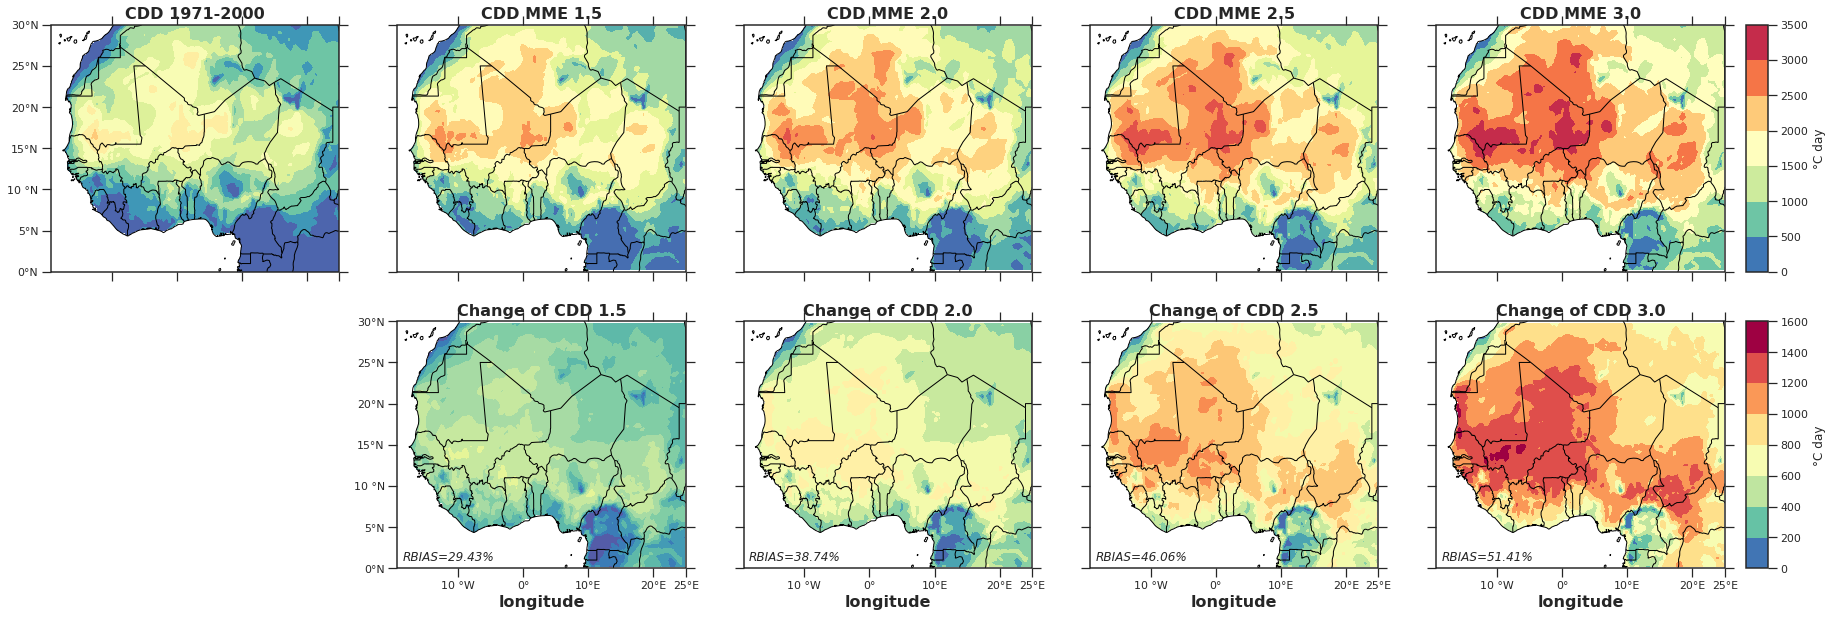

In [309]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =12
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=9
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}E',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()


fig, axes = plt.subplots(2,5,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(30,10)

for i, gwl in enumerate(variables):
    o= axes[0,i].contourf(longitude, latitude,MME_CDD[str(gwl)],
                          transform=projection,cmap='Spectral_r',vmin=0, vmax=3500)
    p= axes[1,i].contourf(longitude, latitude,MME_CDD_bias[str(gwl)],
                          transform=projection,cmap='Spectral_r', vmin=0, vmax=1500)
    
    axes[1,i].text(-18.5,1,
             str('RBIAS='+
                 str(round(xs.mape(MME_CDD[str(gwl)].mean(['lon','lat']),
                                   MME_CDD['Obs'].mean(['lon','lat'])).values*100,
                           2))+'%'),
             fontsize=12, ha='left',fontstyle='italic')
    
#     MME_CDD_bias
    axes[0,i].set_title(str(title[i]),fontsize=16,fontweight='bold')
    
    k=axes[1,:]
    

# fig.colorbar(p,ax=axes[1,:])
    

axes[1, 0].set_visible(False)
axes[1, 0].set_axis_off()
axes[1, 1].set_title('Change of CDD 1.5',fontsize=16,fontweight='bold')
axes[1, 2].set_title('Change of CDD 2.0',fontsize=16,fontweight='bold')
axes[1, 3].set_title('Change of CDD 2.5',fontsize=16,fontweight='bold')
axes[1, 4].set_title('Change of CDD 3.0',fontsize=16,fontweight='bold')



    
# Assign label to y axis
# axes[0].set_ylabel('latitude',fontsize=16,fontweight='bold')
  
    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels)
    ax.axes.axis('tight')

for ax in axes[-1,:].flatten():
    ax.set_xlabel('longitude',fontsize=16,fontweight='bold')

 
    
axes[1,1].yaxis.set_tick_params(which='both', labelleft=True)


# flatten axes and get subplots positions
DP = axes.T.flatten()
# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[8].get_position().x1+0.01,DP[8].get_position().y0,
                 0.01,DP[8].get_position().height])

cax2=fig.add_axes([DP[9].get_position().x1+0.01,DP[9].get_position().y0,
                 0.01,DP[9].get_position().height])

# plt.tight_layout()
# plot colobar on figures
fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')

plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_MME.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_MME.png',transparent=True,dpi=300)



plt.show

In [310]:
## CDD PLOT PIVOTED

<function matplotlib.pyplot.show>

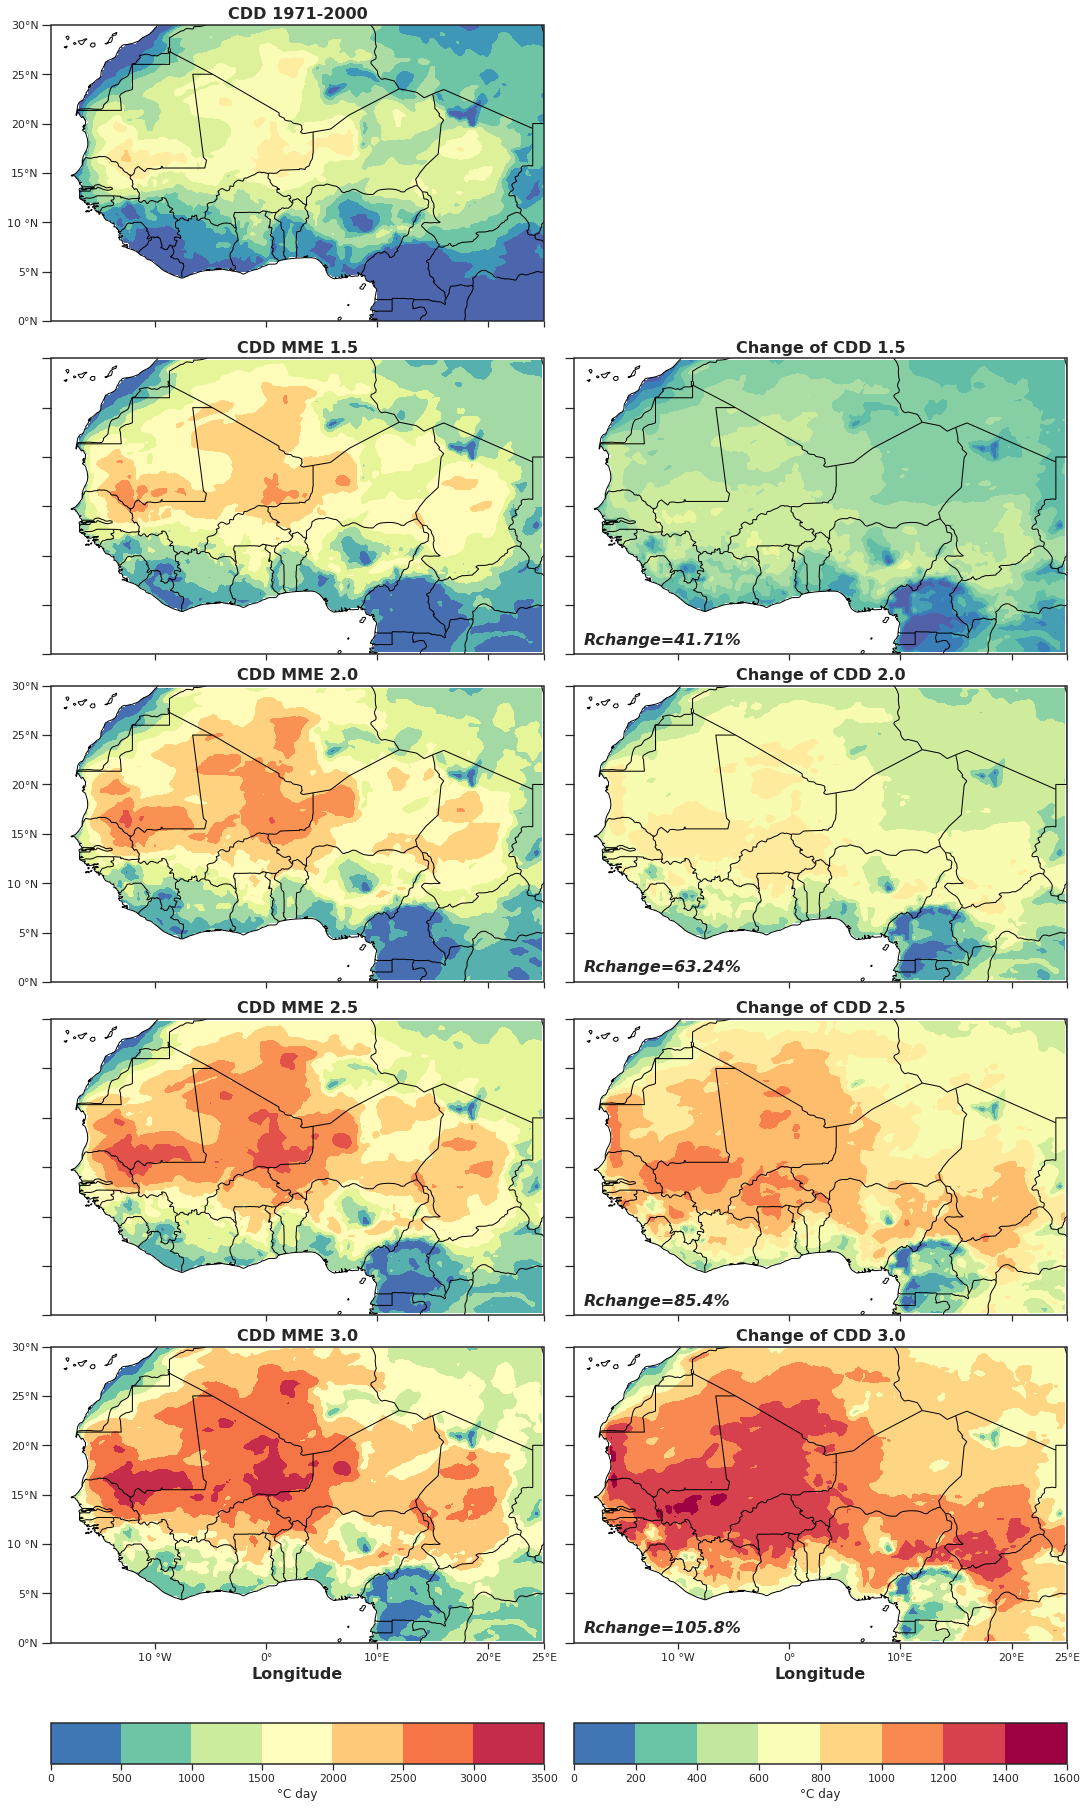

In [311]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =15
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=6
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =False
plt.rcParams['xtick.top'] =False

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}E',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()


fig, axes = plt.subplots(5,2,subplot_kw=dict(projection=ccrs.PlateCarree()),constrained_layout=True)
fig.set_size_inches(15,25)

for i, gwl in enumerate(variables):
    
    o= axes[i,0].contourf(longitude, latitude,MME_CDD[str(gwl)],
                          transform=projection,cmap='Spectral_r',vmin=0, vmax=3500)
    p= axes[i,1].contourf(longitude, latitude,MME_CDD_bias[str(gwl)],
                          transform=projection,cmap='Spectral_r',
                         vmin=0, vmax=MME_CDD_bias['MME_3.0'].max().values)
    
    
    
    axes[i,1].text(-18.5,1,
             str('Rchange='+
                 str(round(relative_change(MME_CDD[str(gwl)].mean(['lon','lat']),
                                   MME_CDD['Obs'].mean(['lon','lat'])),
                           2))+'%'),
             fontsize=16, ha='left',fontstyle='italic',fontweight='bold')
    
    MME_CDD_bias
    axes[i,0].set_title(str(title[i]),fontsize=16,fontweight='bold')  
    

axes[0, 1].set_visible(False)
axes[0, 1].set_axis_off()
axes[1, 1].set_title('Change of CDD 1.5',fontsize=16,fontweight='bold')
axes[2, 1].set_title('Change of CDD 2.0',fontsize=16,fontweight='bold')
axes[3, 1].set_title('Change of CDD 2.5',fontsize=16,fontweight='bold')
axes[4, 1].set_title('Change of CDD 3.0',fontsize=16,fontweight='bold')


axes[1,0].yaxis.set_tick_params(which='both', labelleft=False)
axes[3,0].yaxis.set_tick_params(which='both', labelleft=False)
    
# Assign label to y axis
# axes[0].set_ylabel('latitude',fontsize=16,fontweight='bold')
  
    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels)
    ax.axes.axis('tight')

for ax in axes[-1,:].flatten():
    ax.set_xlabel('Longitude',fontsize=16,fontweight='bold')


fig.colorbar(o, ax=axes[:,0], location='bottom',label='\N{DEGREE SIGN}C day')
fig.colorbar(p, ax=axes[:,1], location='bottom',label='\N{DEGREE SIGN}C day')



plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_MME_T.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_MME_T.png',transparent=True,dpi=300)
fig.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_MME_T.svg', format='svg', dpi=1200)



plt.show
# cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

In [312]:
## Summary of the change

In [313]:
MME_CDD_bias.to_dataframe().describe()

Obs       MME_1.5       MME_2.0       MME_2.5       MME_3.0
count  17205.0  16884.000000  16884.000000  16884.000000  16884.000000
mean       0.0    382.889227    584.695845    792.423388    983.560821
std        0.0    108.847287    156.478634    198.503562    235.597388
min        0.0      0.009941      0.065823      0.110746      0.389557
25%        0.0    323.978770    493.852326    673.494512    838.128170
50%        0.0    395.220035    599.341401    805.103998    991.037998
75%        0.0    466.175954    710.649105    953.875530   1173.504883
max        0.0    588.045917    870.416943   1167.714393   1457.392659

In [314]:
MME_CDD.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/MME_CDD_gwl.csv')
MME_CDD.to_dataframe().describe()

Obs       MME_1.5       MME_2.0       MME_2.5       MME_3.0
count  17205.000000  16884.000000  16884.000000  16884.000000  16884.000000
mean     937.300781   1328.257368   1530.063986   1737.791529   1928.928962
std      531.057251    617.543600    658.180326    690.360916    715.584410
min        0.000000      0.009941      0.065823      0.110746      0.389557
25%      522.139587    882.297531   1061.391880   1241.852768   1408.499250
50%      966.490173   1404.003377   1609.577373   1818.118297   2009.102794
75%     1368.830811   1816.250128   2045.222275   2276.057180   2488.038048
max     2184.953613   2678.422707   2941.235064   3198.453396   3444.585145

In [315]:
MME_CDD_bias.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/MME_CDD_gwL_change.csv')
MME_CDD_bias.to_dataframe().describe()

Obs       MME_1.5       MME_2.0       MME_2.5       MME_3.0
count  17205.0  16884.000000  16884.000000  16884.000000  16884.000000
mean       0.0    382.889227    584.695845    792.423388    983.560821
std        0.0    108.847287    156.478634    198.503562    235.597388
min        0.0      0.009941      0.065823      0.110746      0.389557
25%        0.0    323.978770    493.852326    673.494512    838.128170
50%        0.0    395.220035    599.341401    805.103998    991.037998
75%        0.0    466.175954    710.649105    953.875530   1173.504883
max        0.0    588.045917    870.416943   1167.714393   1457.392659

# Population weighted approach
In this study, the population weighting of degree-days
is achieved by multiplying, for each grid cell, the aver-
aged (over the 30-year period) values of the population
by the averaged degree-day values (ensemble median of
CORDEX simulations). The results, firstly on regular
grids (0.44), are therefore aggregated over macro-regions
(Figure S2) and continents for GWLs from 1.5C to 4C.

Population weighting assures that degree-day averages 
reflect conditions in more densely populated areas of the country. 



The relative changes in population exposure are
estimated by comparing the population exposed at 1.5 C,
2.0 C, and 3.0 C warming levels with that in the reference
period (1986e2005). Considering the different mitigation and
adaptation challenges raised by the selection of different SSPs,
the low emission scenario RCP2.6 is combined with the sustainability pathway (SSP1), the medium emission scenario
RCP4.5 is combined with the historical trend pathway (SSP2),
and the high emission scenario RCP8.5 is combined with a
growth-oriented world (SSP5) (O’Neill et al., 2014, 2017;
Wen et al., 2019; Wang et al., 2020)

In [316]:
## Interpolate first
## Population weighted of CDD
## Countries CDDP
# https://pythonrepo.com/repo/ks905383-xagg-python-general-utilities
# https://climateestimate.net/content/example-step3.html

In [317]:
# os.chdir('/mys3bucket/Historical_cdd/Pop_ssp5/test/') # Setting working directory

In [318]:
## Set time in netcdf files 
# cdo setdate,2010-01-01 ssp5_total_2010_WA_rg.nc  ssp5_total_2010_WA_rg_set.nc &
# cdo setdate,2020-01-01 ssp5_total_2020_WA_rg.nc  ssp5_total_2020_WA_rg_set.nc &
# cdo setdate,2030-01-01 ssp5_total_2030_WA_rg.nc  ssp5_total_2030_WA_rg_set.nc &
# cdo setdate,2040-01-01 ssp5_total_2040_WA_rg.nc  ssp5_total_2040_WA_rg_set.nc &
# cdo setdate,2050-01-01 ssp5_total_2050_WA_rg.nc  ssp5_total_2050_WA_rg_set.nc &
# cdo setdate,2060-01-01 ssp5_total_2060_WA_rg.nc  ssp5_total_2060_WA_rg_set.nc &
# cdo setdate,2070-01-01 ssp5_total_2070_WA_rg.nc  ssp5_total_2070_WA_rg_set.nc &
# cdo setdate,2080-01-01 ssp5_total_2080_WA_rg.nc  ssp5_total_2080_WA_rg_set.nc &
# cdo setdate,2090-01-01 ssp5_total_2090_WA_rg.nc  ssp5_total_2090_WA_rg_set.nc &
# cdo setdate,2100-01-01 ssp5_total_2100_WA_rg.nc  ssp5_total_2100_WA_rg_set.nc &

In [319]:
# ## Generate interpolated files in between each year 
# cdo intyear,2011,2012,2013,2014,2015,2016,2017,2018,2019, ssp5_total_2010_WA_rg_set.nc ssp5_total_2020_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2021,2022,2023,2024,2025,2026,2027,2028,2029, ssp5_total_2020_WA_rg_set.nc ssp5_total_2030_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2031,2032,2033,2034,2035,2036,2037,2038,2039, ssp5_total_2030_WA_rg_set.nc ssp5_total_2040_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2041,2042,2043,2044,2045,2046,2047,2048,2049, ssp5_total_2040_WA_rg_set.nc ssp5_total_2050_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2051,2052,2053,2054,2055,2056,2057,2058,2059, ssp5_total_2050_WA_rg_set.nc ssp5_total_2060_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2061,2062,2063,2064,2065,2066,2067,2068,2069, ssp5_total_2060_WA_rg_set.nc ssp5_total_2070_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2071,2072,2073,2074,2075,2076,2077,2078,2079, ssp5_total_2070_WA_rg_set.nc ssp5_total_2080_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2081,2082,2083,2084,2085,2086,2087,2088,2089, ssp5_total_2080_WA_rg_set.nc ssp5_total_2090_WA_rg_set.nc ssp5_total_set &
# cdo intyear,2091,2092,2093,2094,2095,2096,2097,2098,2099, ssp5_total_2090_WA_rg_set.nc ssp5_total_2100_WA_rg_set.nc ssp5_total_set &

## Compute Population gobal warming levels

In [320]:
MME_CDD

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 181)
Coordinates:
  * lon      (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.25 24.5 24.75 25.0
  * lat      (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 1.0 0.75 0.5 0.25 0.0
Data variables:
    Obs      (lat, lon) float32 nan nan nan nan nan ... 42.45 32.06 31.88 32.04
    MME_1.5  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_2.0  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_2.5  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_3.0  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [321]:
glob('/mys3bucket/Pop_ssp5/CLIM_MMM_Pop_SSP5_GWL*.nc')

['/mys3bucket/Historical_cdd/Pop_ssp5/CLIM_MMM_Pop_SSP5_GWL_1.5_WA.nc',
 '/mys3bucket/Historical_cdd/Pop_ssp5/CLIM_MMM_Pop_SSP5_GWL_2.0_WA.nc',
 '/mys3bucket/Historical_cdd/Pop_ssp5/CLIM_MMM_Pop_SSP5_GWL_2.5_WA.nc',
 '/mys3bucket/Historical_cdd/Pop_ssp5/CLIM_MMM_Pop_SSP5_GWL_3.0_WA.nc']

In [322]:
## We assumed population in 2000 as the average of the historical period (1971-2000)

In [323]:
# import population data
Pop_ssp5=xr.open_dataset('/mys3bucket/Pop_ssp5/ssp5_total_2010_WA_rg_set.nc')
## Assign proper time indexes
Pop_ssp5['time']=pd.date_range("2000-01-01", freq="1Y", periods=1)
Pop_ssp5=Pop_ssp5.rename({'Band1':'Pop_Obs'})

In [324]:
Pop_ssp5['Pop_1.5']=xr.open_dataset('/mys3bucket/Pop_ssp5/CLIM_MMM_Pop_SSP5_GWL_1.5_WA.nc').Band1
Pop_ssp5['Pop_2.0']=xr.open_dataset('/mys3bucket/Pop_ssp5/CLIM_MMM_Pop_SSP5_GWL_2.0_WA.nc').Band1
Pop_ssp5['Pop_2.5']=xr.open_dataset('/mys3bucket/Pop_ssp5/CLIM_MMM_Pop_SSP5_GWL_2.5_WA.nc').Band1
Pop_ssp5['Pop_3.0']=xr.open_dataset('/mys3bucket/Pop_ssp5/CLIM_MMM_Pop_SSP5_GWL_3.0_WA.nc').Band1

In [325]:
Pop_ssp5=Pop_ssp5.mean('time')

In [326]:
MME_CDDP=Pop_ssp5
MME_CDDP=MME_CDDP.rename({'Pop_Obs':'CDDP_Obs',
                          'Pop_1.5':'CDDP_1.5',
                          'Pop_2.0':'CDDP_2.0',
                          'Pop_2.5':'CDDP_2.5',
                          'Pop_3.0':'CDDP_3.0'})


## COMPUTE WEIGHTED POPULATION COOLING DEGREE DAYS

In [327]:
MME_CDDP['CDDP_1.5']=Pop_ssp5['Pop_1.5']*MME_CDD['MME_1.5']
MME_CDDP['CDDP_2.0']=Pop_ssp5['Pop_2.0']*MME_CDD['MME_2.0']
MME_CDDP['CDDP_2.5']=Pop_ssp5['Pop_2.5']*MME_CDD['MME_2.5']
MME_CDDP['CDDP_3.0']=Pop_ssp5['Pop_3.0']*MME_CDD['MME_3.0']
MME_CDDP['CDDP_Obs']=Pop_ssp5['Pop_Obs']*MME_CDD['Obs']

In [328]:
Pop_ssp5

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 181)
Coordinates:
  * lon      (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.25 24.5 24.75 25.0
  * lat      (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 1.0 0.75 0.5 0.25 0.0
Data variables:
    Pop_Obs  (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Pop_1.5  (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Pop_2.0  (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Pop_2.5  (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Pop_3.0  (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [329]:
MME_CDD_bias

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 181)
Coordinates:
  * lon      (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.25 24.5 24.75 25.0
  * lat      (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 1.0 0.75 0.5 0.25 0.0
Data variables:
    Obs      (lat, lon) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    MME_1.5  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_2.0  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_2.5  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    MME_3.0  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [330]:
import geopandas as gpd

In [331]:
## import west african countries shapefiles

In [332]:
states_gdf = gpd.read_file('/mys3bucket/ERA_Temp/West_Africa_shapefile/west_africa_shape_new.shp',crs="epsg:4326")
states_gdf.head()

fid iso_a2                  NAME FIPS_10_ ISO_A3 WB_A2 WB_A3  \
0  216.0     TD                  Chad       CD    TCD    TD   TCD   
1  273.0     SL          Sierra Leone       SL    SLE    SL   SLE   
2  274.0     GN                Guinea       GV    GIN    GN   GIN   
3  275.0     CF  Central African Rep.       CT    CAF    CF   CAF   
4  301.0     NG               Nigeria       NI    NGA    NG   NGA   

                                            geometry  
0  POLYGON ((18.17543 8.02195, 18.07045 8.01920, ...  
1  MULTIPOLYGON (((-12.49299 7.56802, -12.50182 7...  
2  POLYGON ((-13.64327 9.54254, -13.72240 9.50580...  
3  POLYGON ((16.42749 2.72649, 16.19666 2.23645, ...  
4  MULTIPOLYGON (((7.27418 4.49189, 7.33253 4.491...

In [333]:
# ! pip install rioxarray

In [334]:
import rioxarray
from shapely.geometry import mapping

In [335]:
MME_CDDP

<xarray.Dataset>
Dimensions:   (lat: 121, lon: 181)
Coordinates:
  * lon       (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.25 24.5 24.75 25.0
  * lat       (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 1.0 0.75 0.5 0.25 0.0
Data variables:
    CDDP_Obs  (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    CDDP_1.5  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    CDDP_2.0  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    CDDP_2.5  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    CDDP_3.0  (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [336]:
states_gdf.head()

fid iso_a2                  NAME FIPS_10_ ISO_A3 WB_A2 WB_A3  \
0  216.0     TD                  Chad       CD    TCD    TD   TCD   
1  273.0     SL          Sierra Leone       SL    SLE    SL   SLE   
2  274.0     GN                Guinea       GV    GIN    GN   GIN   
3  275.0     CF  Central African Rep.       CT    CAF    CF   CAF   
4  301.0     NG               Nigeria       NI    NGA    NG   NGA   

                                            geometry  
0  POLYGON ((18.17543 8.02195, 18.07045 8.01920, ...  
1  MULTIPOLYGON (((-12.49299 7.56802, -12.50182 7...  
2  POLYGON ((-13.64327 9.54254, -13.72240 9.50580...  
3  POLYGON ((16.42749 2.72649, 16.19666 2.23645, ...  
4  MULTIPOLYGON (((7.27418 4.49189, 7.33253 4.491...

In [337]:
# https://towardsdatascience.com/how-to-use-python-to-obtain-the-temperature-of-any-place-on-earth-b92aae44b831

In [338]:
Data_temp=MME_CDDP

In [339]:
# convert into standard CRS 
Data_temp.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:      (lat: 121, lon: 181)
Coordinates:
  * lon          (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.5 24.75 25.0
  * lat          (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 0.75 0.5 0.25 0.0
    spatial_ref  int64 0
Data variables:
    CDDP_Obs     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_1.5     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_2.0     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_2.5     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_3.0     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [340]:
Data_temp

<xarray.Dataset>
Dimensions:      (lat: 121, lon: 181)
Coordinates:
  * lon          (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.5 24.75 25.0
  * lat          (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 0.75 0.5 0.25 0.0
    spatial_ref  int64 0
Data variables:
    CDDP_Obs     (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_1.5     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_2.0     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_2.5     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_3.0     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [341]:
## Masking data per country vector files and generate variable output

In [342]:
temp_country = {}
small_countries = []
for i in range(states_gdf.shape[0]):
    data = states_gdf[states_gdf.index==i]
    try:
        clip = Data_temp.rio.clip(data.geometry.apply(mapping), data.crs).mean(dim=['lon','lat'])
        temp_country[states_gdf.iloc[i]['NAME']] = clip
        
    except:
        small_countries.append(states_gdf.iloc[i]['NAME'])

In [343]:
temp_country

{'Algeria': <xarray.Dataset>
 Dimensions:      ()
 Coordinates:
     spatial_ref  int64 0
 Data variables:
     CDDP_Obs     float32 525.2
     CDDP_1.5     float64 804.6
     CDDP_2.0     float64 939.1
     CDDP_2.5     float64 1.029e+03
     CDDP_3.0     float64 1.075e+03, 'Benin': <xarray.Dataset>
 Dimensions:      ()
 Coordinates:
     spatial_ref  int64 0
 Data variables:
     CDDP_Obs     float32 2.835e+04
     CDDP_1.5     float64 6.479e+04
     CDDP_2.0     float64 9.32e+04
     CDDP_2.5     float64 1.189e+05
     CDDP_3.0     float64 1.399e+05, 'Burkina Faso': <xarray.Dataset>
 Dimensions:      ()
 Coordinates:
     spatial_ref  int64 0
 Data variables:
     CDDP_Obs     float32 5.512e+04
     CDDP_1.5     float64 1.165e+05
     CDDP_2.0     float64 1.613e+05
     CDDP_2.5     float64 1.996e+05
     CDDP_3.0     float64 2.323e+05, 'Cameroon': <xarray.Dataset>
 Dimensions:      ()
 Coordinates:
     spatial_ref  int64 0
 Data variables:
     CDDP_Obs     float32 1.07e+04
     C

In [344]:
# small_countries

In [345]:
dd=pd.DataFrame()
for key in temp_country.keys():
    tmp=temp_country[key]
    tmp2=tmp.expand_dims("Country").to_dataframe().reset_index().drop(columns='spatial_ref')
    tmp2['Country']=str(key)
    
    dd=dd.append(tmp2)

In [346]:
dd.head()

Country      CDDP_Obs       CDDP_1.5       CDDP_2.0  \
0                  Chad   7742.197754   16150.928113   22521.488825   
0          Sierra Leone  31777.623047  102411.176387  156632.899656   
0                Guinea  11098.378906   27234.378558   36121.515763   
0  Central African Rep.   1607.969971    4419.467741    6503.275587   
0               Nigeria  93535.937500  224510.096700  340457.471715   

        CDDP_2.5       CDDP_3.0  
0   28098.261720   32617.363176  
0  210149.472385  256260.377472  
0   43893.925271   50007.829375  
0    8614.634767   10400.090266  
0  460548.847667  575163.113388

In [347]:
dd.to_csv('/mys3bucket/cdd_output/summary_cddp_country_new_21_10_2023.csv')

In [348]:
## Merge datasets

In [349]:
MME_CDD_bias_new=MME_CDD_bias.rename({'Obs':'Obs_bias',
                                  'MME_1.5':'MME_1.5_bias',
                                  'MME_2.0':'MME_2.0_bias',
                                  'MME_2.5':'MME_2.5_bias',
                                  'MME_3.0':'MME_3.0_bias'})

In [350]:
all_files=xr.merge([MME_CDDP,MME_CDD,MME_CDD_bias_new])

In [351]:
variables_cddp=['CDDP_Obs','CDDP_1.5','CDDP_2.0','CDDP_2.5','CDDP_3.0']

## Plot - Ensemean of CDDP of models per GWLs and Relative change

<function matplotlib.pyplot.show>

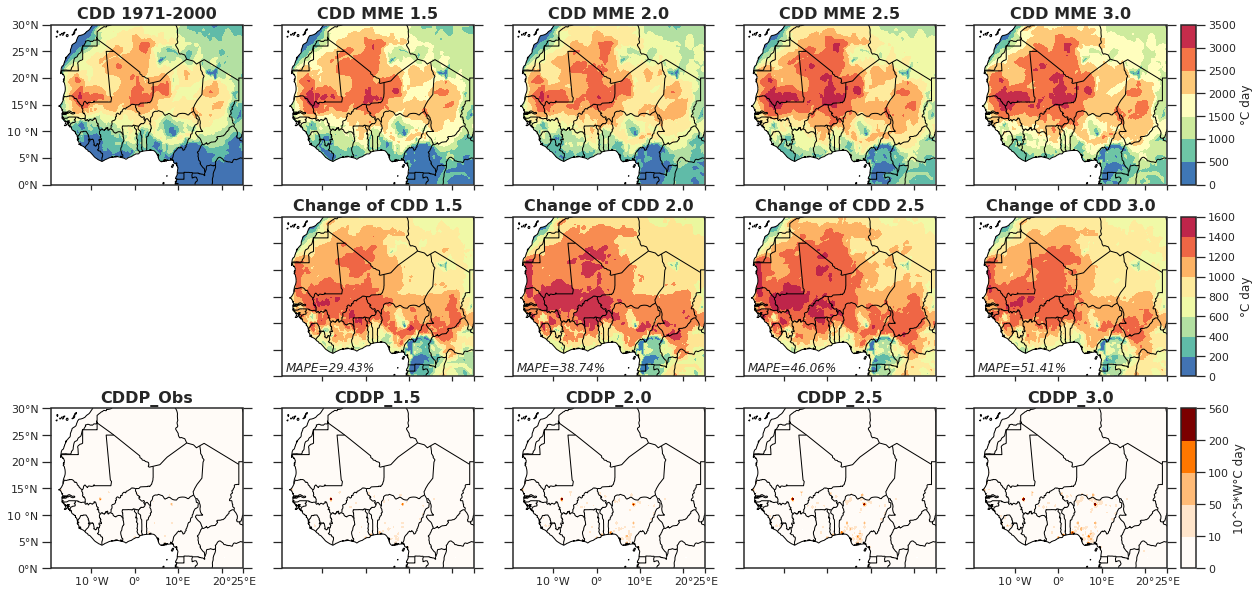

In [352]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =12
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=5
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()
# [0,5,10,15,20,25,90,100,200,250,400,600]
n_levels =[0,10,50,100,200,560]
fig, axes = plt.subplots(3,5,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,10)

for i, gwl in enumerate(variables):
    o= axes[0,i].contourf(longitude, latitude,MME_CDD[str(gwl)],
                          transform=projection,cmap='Spectral_r')
    p= axes[1,i].contourf(longitude, latitude,MME_CDD_bias[str(gwl)],
                          transform=projection,cmap='Spectral_r')
    q= axes[2,i].contourf(longitude, latitude,MME_CDDP[str(variables_cddp[i])]/100000,
                          transform=projection,cmap='gist_heat_r',levels=n_levels)
#     q= axes[2,i].plot(longitude, latitude,MME_CDDP[str(variables_cddp[i])]/100000)

    axes[1,i].text(-18.5,1,
             str('MAPE='+
                 str(round(xs.mape(MME_CDD[str(gwl)].mean(['lon','lat']),
                                   MME_CDD['Obs'].mean(['lon','lat'])).values*100,
                           2))+'%'),
             fontsize=12, ha='left',fontstyle='italic')
    
 
    axes[0,i].set_title(str(title[i]),fontsize=16,fontweight='bold') 
    axes[2,i].set_title(str(variables_cddp[i]),fontsize=16,fontweight='bold')
    

axes[1, 0].set_visible(False)
axes[1, 0].set_axis_off()
axes[2, 0].set_visible(True)
# axes[2, 0].set_axis_off()

axes[1, 1].set_title('Change of CDD 1.5',fontsize=16,fontweight='bold')
axes[1, 2].set_title('Change of CDD 2.0',fontsize=16,fontweight='bold')
axes[1, 3].set_title('Change of CDD 2.5',fontsize=16,fontweight='bold')
axes[1, 4].set_title('Change of CDD 3.0',fontsize=16,fontweight='bold')

    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels)
    ax.tick_params(top=False)
#     ax.tick_params(right=False)
    ax.axes.axis('tight')

# for ax in axes[-1,:].flatten():
#     ax.set_xlabel('longitude',fontsize=16,fontweight='bold')

 
    
axes[2,1].xaxis.set_tick_params(which='both', labelbottom=False)
axes[2,3].xaxis.set_tick_params(which='both', labelbottom=False)
# https://matplotlib.org/2.0.2/faq/usage_faq.html

# # flatten axes and get subplots positions
DP = axes.T.flatten()
# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[12].get_position().x1+0.01,DP[12].get_position().y0,
                 0.01,DP[12].get_position().height])

cax2=fig.add_axes([DP[13].get_position().x1+0.01,DP[13].get_position().y0,
                 0.01,DP[13].get_position().height])

cax3=fig.add_axes([DP[14].get_position().x1+0.01,DP[14].get_position().y0,
                 0.01,DP[14].get_position().height])
# plt.tight_layout()
# plot colobar on figures

fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='10^5*W\N{DEGREE SIGN}C day')


plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new.png',transparent=True,dpi=300)



plt.show

## Log transformation of CDDP data to smooth high outliers

In [353]:
MME_CDDP_LOG=np.log10(MME_CDDP)

/home/ubuntu/.local/lib/python3.6/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


## Plot - Ensemean of CDDP of models per GWLs and Relative change

In [354]:
MME_CDD.to_dataframe().describe()

Obs       MME_1.5       MME_2.0       MME_2.5       MME_3.0
count  17205.000000  16884.000000  16884.000000  16884.000000  16884.000000
mean     937.300781   1328.257368   1530.063986   1737.791529   1928.928962
std      531.057251    617.543600    658.180326    690.360916    715.584410
min        0.000000      0.009941      0.065823      0.110746      0.389557
25%      522.139587    882.297531   1061.391880   1241.852768   1408.499250
50%      966.490173   1404.003377   1609.577373   1818.118297   2009.102794
75%     1368.830811   1816.250128   2045.222275   2276.057180   2488.038048
max     2184.953613   2678.422707   2941.235064   3198.453396   3444.585145

In [355]:
MME_CDD_bias.to_dataframe().describe()

Obs       MME_1.5       MME_2.0       MME_2.5       MME_3.0
count  17205.0  16884.000000  16884.000000  16884.000000  16884.000000
mean       0.0    382.889227    584.695845    792.423388    983.560821
std        0.0    108.847287    156.478634    198.503562    235.597388
min        0.0      0.009941      0.065823      0.110746      0.389557
25%        0.0    323.978770    493.852326    673.494512    838.128170
50%        0.0    395.220035    599.341401    805.103998    991.037998
75%        0.0    466.175954    710.649105    953.875530   1173.504883
max        0.0    588.045917    870.416943   1167.714393   1457.392659

In [356]:
MME_CDDP_LOG.to_dataframe().describe()

CDDP_Obs      CDDP_1.5      CDDP_2.0      CDDP_2.5      CDDP_3.0  \
count  1.683300e+04  1.683300e+04  1.683300e+04  1.683300e+04  1.683300e+04   
mean           -inf          -inf          -inf          -inf          -inf   
std             NaN           NaN           NaN           NaN           NaN   
min            -inf          -inf          -inf          -inf          -inf   
25%    2.224639e+00  2.538169e+00  2.643286e+00  2.714946e+00  2.755161e+00   
50%    2.901040e+00  3.205630e+00  3.378140e+00  3.479364e+00  3.549743e+00   
75%    3.979457e+00  4.315543e+00  4.457268e+00  4.564529e+00  4.631927e+00   
max    7.003657e+00  7.368023e+00  7.523014e+00  7.632482e+00  7.711422e+00   

       spatial_ref  
count      21901.0  
mean           0.0  
std            0.0  
min            0.0  
25%            0.0  
50%            0.0  
75%            0.0  
max            0.0

In [357]:
MME_CDDP_LOG['CDDP_3.0'].max().values

array(7.71142241)

<function matplotlib.pyplot.show>

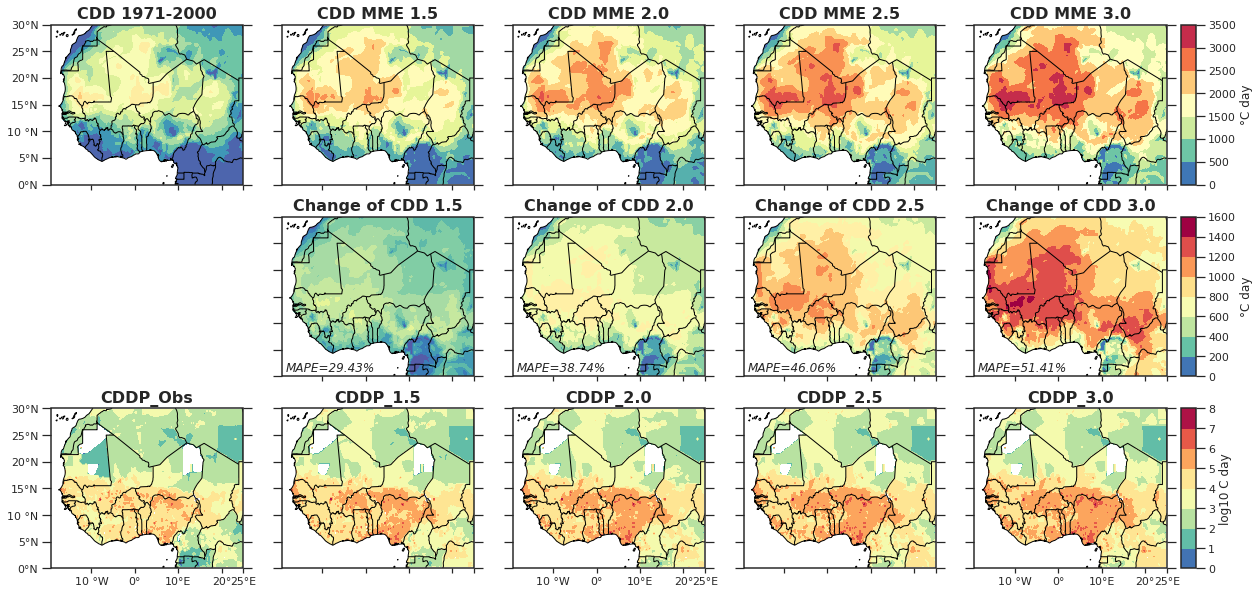

In [358]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =12
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=5
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()
# [0,5,10,15,20,25,90,100,200,250,400,600]
n_levels =[0,10,50,100,200,560]
fig, axes = plt.subplots(3,5,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,10)

for i, gwl in enumerate(variables):
    o= axes[0,i].contourf(longitude, latitude,MME_CDD[str(gwl)],
                          transform=projection,cmap='Spectral_r',vmin=0, vmax=3500)
    p= axes[1,i].contourf(longitude, latitude,MME_CDD_bias[str(gwl)],
                          transform=projection,cmap='Spectral_r',vmin=0, vmax=1500)
    q= axes[2,i].contourf(longitude, latitude,MME_CDDP_LOG[str(variables_cddp[i])],
                          transform=projection,cmap='Spectral_r',
                          vmin=0,vmax=MME_CDDP_LOG['CDDP_3.0'].max().values)
#     q= axes[2,i].plot(longitude, latitude,MME_CDDP[str(variables_cddp[i])]/100000)

    axes[1,i].text(-18.5,1,
             str('MAPE='+
                 str(round(xs.mape(MME_CDD[str(gwl)].mean(['lon','lat']),
                                   MME_CDD['Obs'].mean(['lon','lat'])).values*100,
                           2))+'%'),
             fontsize=12, ha='left',fontstyle='italic')
    
 
    axes[0,i].set_title(str(title[i]),fontsize=16,fontweight='bold') 
    axes[2,i].set_title(str(variables_cddp[i]),fontsize=16,fontweight='bold')
    

axes[1, 0].set_visible(False)
axes[1, 0].set_axis_off()
axes[2, 0].set_visible(True)
# axes[2, 0].set_axis_off()

axes[1, 1].set_title('Change of CDD 1.5',fontsize=16,fontweight='bold')
axes[1, 2].set_title('Change of CDD 2.0',fontsize=16,fontweight='bold')
axes[1, 3].set_title('Change of CDD 2.5',fontsize=16,fontweight='bold')
axes[1, 4].set_title('Change of CDD 3.0',fontsize=16,fontweight='bold')

    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels)
    ax.tick_params(top=False)
#     ax.tick_params(right=False)
    ax.axes.axis('tight')

# for ax in axes[-1,:].flatten():
#     ax.set_xlabel('longitude',fontsize=16,fontweight='bold')

 
    
axes[2,1].xaxis.set_tick_params(which='both', labelbottom=False)
axes[2,3].xaxis.set_tick_params(which='both', labelbottom=False)
# https://matplotlib.org/2.0.2/faq/usage_faq.html

# # flatten axes and get subplots positions
DP = axes.T.flatten()
# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[12].get_position().x1+0.01,DP[12].get_position().y0,
                 0.01,DP[12].get_position().height])

cax2=fig.add_axes([DP[13].get_position().x1+0.01,DP[13].get_position().y0,
                 0.01,DP[13].get_position().height])

cax3=fig.add_axes([DP[14].get_position().x1+0.01,DP[14].get_position().y0,
                 0.01,DP[14].get_position().height])
# plt.tight_layout()
# plot colobar on figures

fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='log10 C day')


plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new.png',transparent=True,dpi=300)



plt.show
# https://matplotlib.org/3.5.0/gallery/subplots_axes_and_figures/colorbar_placement.html

In [359]:
variables_cddp=['CDDP_Obs','CDDP_1.5','CDDP_2.0','CDDP_2.5','CDDP_3.0']

In [360]:
MME_CDDP_LOG_BIAS=MME_CDDP_LOG-MME_CDDP_LOG['CDDP_Obs']

In [361]:
MME_CDDP=MME_CDDP.drop(labels='spatial_ref')

In [362]:
## Plot - Ensemean of CDDP of models per GWLs and Relative change

## CDDP plot using log transformation

In [363]:
MME_CDDP_BIAS=MME_CDDP-MME_CDDP['CDDP_Obs']

In [364]:
## Plot - Ensemean of CDDP of models per GWLs and Relative change

In [365]:
import numpy as np
def relative_change(y_fut,y_obs):
    y_obs, y_fut = np.array(y_obs), np.array(y_fut)
    return np.mean(np.abs((y_fut - y_obs) / y_obs)) * 100

<function matplotlib.pyplot.show>

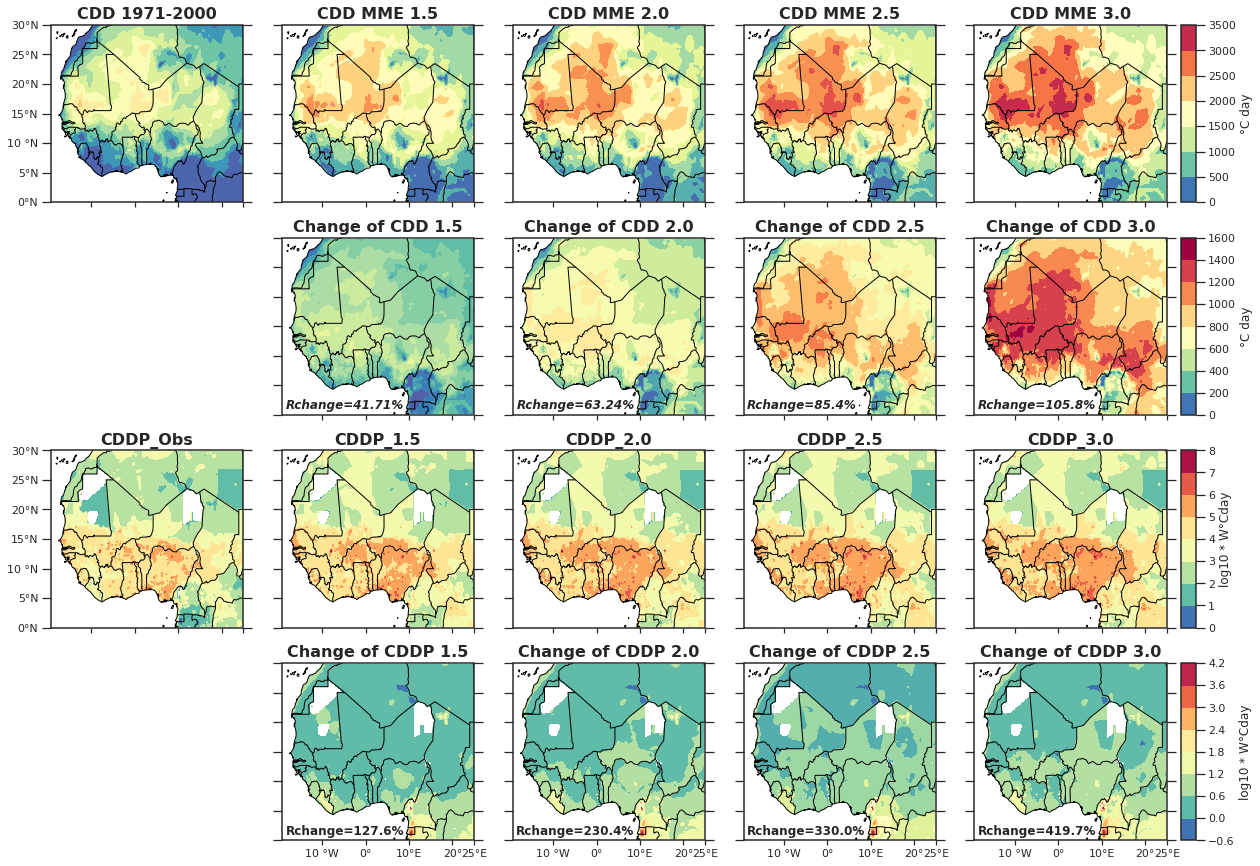

In [366]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =14
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=5
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()
# [0,5,10,15,20,25,90,100,200,250,400,600]
n_levels =[0,10,50,100,200,560]
fig, axes = plt.subplots(4,5,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,15)

for i, gwl in enumerate(variables):
    o= axes[0,i].contourf(longitude, latitude,MME_CDD[str(gwl)],
                          transform=projection,cmap='Spectral_r',vmin=0, vmax=3500)
    p= axes[1,i].contourf(longitude, latitude,MME_CDD_bias[str(gwl)],
                          transform=projection,cmap='Spectral_r',
                         vmin=0, vmax=MME_CDD_bias['MME_3.0'].max().values)
    q= axes[2,i].contourf(longitude, latitude,MME_CDDP_LOG[str(variables_cddp[i])],
                          transform=projection,cmap='Spectral_r',
                         vmin=0,vmax=MME_CDDP_LOG['CDDP_3.0'].max().values)
    r= axes[3,i].contourf(longitude, latitude,MME_CDDP_LOG_BIAS[str(variables_cddp[i])],
                          transform=projection,cmap='Spectral_r')
    
    
    axes[1,i].text(-18.5,1,
             str('Rchange='+
                 str(round(relative_change(MME_CDD[str(gwl)].mean(['lon','lat']),
                                   MME_CDD['Obs'].mean(['lon','lat'])),
                           2))+'%'),
             fontsize=12, ha='left',fontstyle='italic',fontweight='bold')
    axes[3,i].text(-18.5,1,
             str('Rchange='+
                 str(round(relative_change(MME_CDDP[str(variables_cddp[i])].mean(['lon','lat']),
                                   MME_CDDP['CDDP_Obs'].mean(['lon','lat'])),
                           1))+'%'),
             fontsize=12, ha='left',fontweight='bold')
    
 
    axes[0,i].set_title(str(title[i]),fontsize=16,fontweight='bold') 
    axes[2,i].set_title(str(variables_cddp[i]),fontsize=16,fontweight='bold')
    

axes[1, 0].set_visible(False)
axes[1, 0].set_axis_off()
axes[2, 0].set_visible(True)
# axes[2, 0].set_axis_off()

axes[1, 1].set_title('Change of CDD 1.5',fontsize=16,fontweight='bold')
axes[1, 2].set_title('Change of CDD 2.0',fontsize=16,fontweight='bold')
axes[1, 3].set_title('Change of CDD 2.5',fontsize=16,fontweight='bold')
axes[1, 4].set_title('Change of CDD 3.0',fontsize=16,fontweight='bold')

axes[3, 0].set_visible(False)
axes[3, 0].set_axis_off()
axes[3, 1].set_title('Change of CDDP 1.5',fontsize=16,fontweight='bold')
axes[3, 2].set_title('Change of CDDP 2.0',fontsize=16,fontweight='bold')
axes[3, 3].set_title('Change of CDDP 2.5',fontsize=16,fontweight='bold')
axes[3, 4].set_title('Change of CDDP 3.0',fontsize=16,fontweight='bold')

    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels)
    ax.tick_params(top=False)
#     ax.tick_params(right=False)
    ax.axes.axis('tight')

    
axes[2,1].xaxis.set_tick_params(which='both', labelbottom=False)
axes[2,3].xaxis.set_tick_params(which='both', labelbottom=False)
# https://matplotlib.org/2.0.2/faq/usage_faq.html

# # flatten axes and get subplots positions
DP = axes.T.flatten()
# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[16].get_position().x1+0.01,DP[16].get_position().y0,
                 0.01,DP[16].get_position().height])

cax2=fig.add_axes([DP[17].get_position().x1+0.01,DP[17].get_position().y0,
                 0.01,DP[17].get_position().height])

cax3=fig.add_axes([DP[18].get_position().x1+0.01,DP[18].get_position().y0,
                 0.01,DP[18].get_position().height])
cax4=fig.add_axes([DP[19].get_position().x1+0.01,DP[19].get_position().y0,
                 0.01,DP[19].get_position().height])
# plt.tight_layout()
# plot colobar on figures

fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='log10 * W\N{DEGREE SIGN}Cday')
fig.colorbar(r, cax=cax4,label='log10 * W\N{DEGREE SIGN}Cday')


# plt.savefig('/mys3bucket/cdd_output/CDD_gwl_change_CDDP_LOG_poster.eps', format='eps')
# plt.savefig('/mys3bucket/cdd_output/CDD_gwl_change_CDDP_LOG_poster.png',dpi=300)

plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_CDDP_LOG_poster.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_CDDP_LOG_poster.png',dpi=300)


plt.show

In [367]:
MME_CDDP_BIAS=MME_CDDP-MME_CDDP['CDDP_Obs']
variables_cddp_label=['CDDP Obs','CDDP 1.5','CDDP 2.0','CDDP 2.5','CDDP 3.0']

<function matplotlib.pyplot.show>

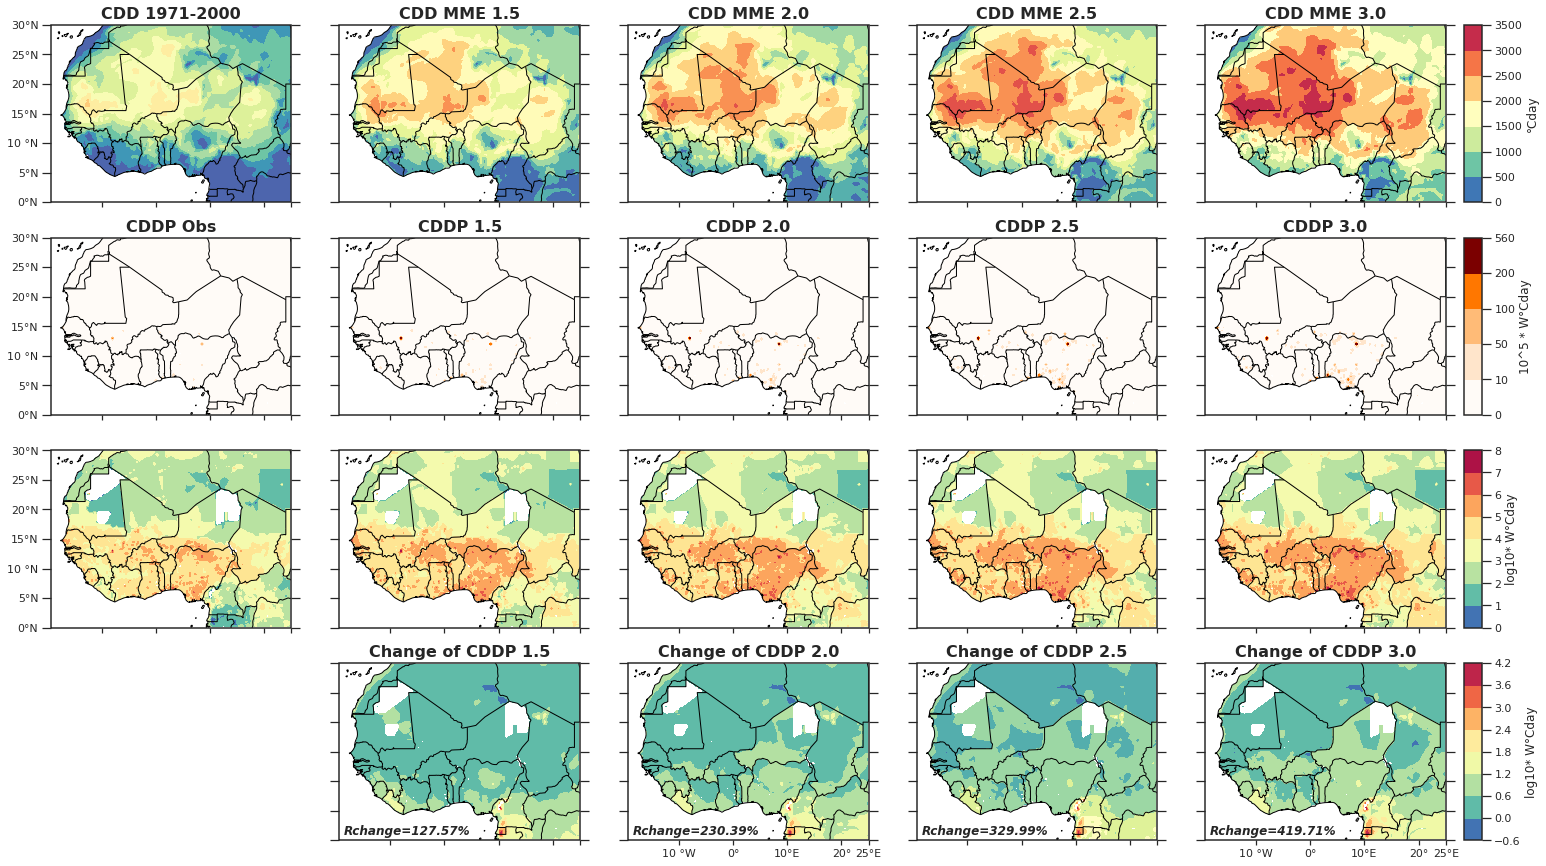

In [368]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =16
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=5
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()
# [0,5,10,15,20,25,90,100,200,250,400,600]
n_levels =[0,10,50,100,200,560]
fig, axes = plt.subplots(4,5,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(25,15)

for i, gwl in enumerate(variables):
    o= axes[0,i].contourf(longitude, latitude,MME_CDD[str(gwl)],
                          transform=projection,cmap='Spectral_r',vmin=0, vmax=3500)
    
    p= axes[1,i].contourf(longitude, latitude,MME_CDDP[str(variables_cddp[i])]/100000,
                          transform=projection,cmap='gist_heat_r',levels=n_levels)
    q= axes[2,i].contourf(longitude, latitude,MME_CDDP_LOG[str(variables_cddp[i])],
                          transform=projection,cmap='Spectral_r',
                         vmin=0,vmax=MME_CDDP_LOG['CDDP_3.0'].max().values)
    r= axes[3,i].contourf(longitude, latitude,MME_CDDP_LOG_BIAS[str(variables_cddp[i])],
                          transform=projection,cmap='Spectral_r')    
    
    

    axes[0,i].set_title(str(title[i]),fontsize=16,fontweight='bold') 
    axes[1,i].set_title(str(variables_cddp_label[i]),fontsize=16,fontweight='bold')
    axes[3,i].text(-18.5,1,
             str('Rchange='+
                 str(round(relative_change(MME_CDDP[str(variables_cddp[i])].mean(['lon','lat']),
                                   MME_CDDP['CDDP_Obs'].mean(['lon','lat'])),
                           2))+'%'),
             fontsize=12, ha='left',fontstyle='italic',fontweight='bold')
    



axes[3, 0].set_visible(False)
axes[3, 0].set_axis_off()
axes[3, 1].set_title('Change of CDDP 1.5',fontsize=16,fontweight='bold')
axes[3, 2].set_title('Change of CDDP 2.0',fontsize=16,fontweight='bold')
axes[3, 3].set_title('Change of CDDP 2.5',fontsize=16,fontweight='bold')
axes[3, 4].set_title('Change of CDDP 3.0',fontsize=16,fontweight='bold')

    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels)
    ax.tick_params(top=False)
#     ax.tick_params(right=False)
    ax.axes.axis('tight')

 
    
axes[3,1].xaxis.set_tick_params(which='both', labelbottom=False)
axes[3,3].xaxis.set_tick_params(which='both', labelbottom=False)
# https://matplotlib.org/2.0.2/faq/usage_faq.html

# # flatten axes and get subplots positions
DP = axes.T.flatten()
# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[16].get_position().x1+0.01,DP[16].get_position().y0,
                 0.01,DP[16].get_position().height])

cax2=fig.add_axes([DP[17].get_position().x1+0.01,DP[17].get_position().y0,
                 0.01,DP[17].get_position().height])

cax3=fig.add_axes([DP[18].get_position().x1+0.01,DP[18].get_position().y0,
                 0.01,DP[18].get_position().height])
cax4=fig.add_axes([DP[19].get_position().x1+0.01,DP[19].get_position().y0,
                 0.01,DP[19].get_position().height])
# plt.tight_layout()
# plot colobar on figures
fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}Cday')
fig.colorbar(p, cax=cax2,label='10^5 * W\N{DEGREE SIGN}Cday')
fig.colorbar(q, cax=cax3,label='log10* W\N{DEGREE SIGN}Cday')
fig.colorbar(r, cax=cax4,label='log10* W\N{DEGREE SIGN}Cday')


plt.savefig('/mys3bucket/cdd_output/Figures/CDDP_gwl_log_CDDP_Change_main.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDDP_gwl_log_CDDP_Change_main.png',transparent=True,dpi=300)
plt.savefig('/mys3bucket/cdd_output/Figures/CDDP_gwl_log_CDDP_Change_main.svg', format='svg', dpi=1200)



plt.show

<function matplotlib.pyplot.show>

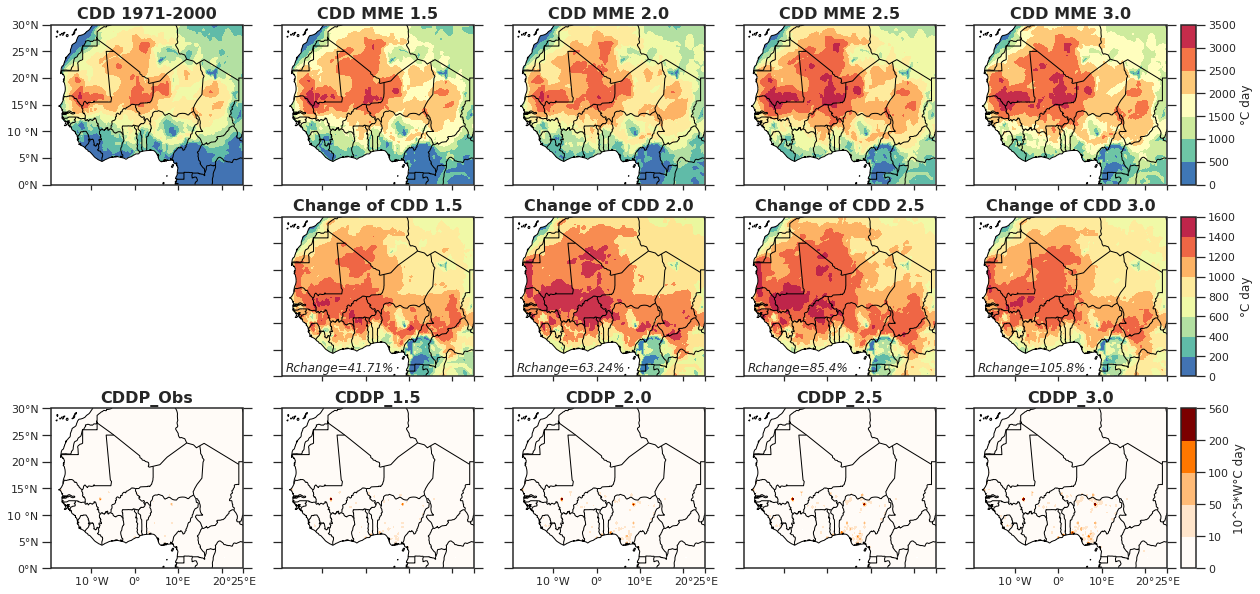

In [369]:
import matplotlib
# Plotting all the subplots
matplotlib.rcParams['font.size'] =12
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'New Century Schoolbook'
plt.rcParams["xtick.major.size"]=5
plt.rcParams["ytick.major.size"]=9
plt.rcParams['ytick.right'] =True
plt.rcParams['xtick.top'] =True

# Define x, y axis labels
x_tick_labels = [u'20\N{DEGREE SIGN}W',u'10 \N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}',u'10\N{DEGREE SIGN}E',
                 u'20\N{DEGREE SIGN}',u'25\N{DEGREE SIGN}E']

y_tick_labels = [u'0\N{DEGREE SIGN}N', u'5\N{DEGREE SIGN}N', u'10 \N{DEGREE SIGN}N',
                 u'15\N{DEGREE SIGN}N',u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N']


import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Plotting all the subplots
projection = ccrs.PlateCarree()
# [0,5,10,15,20,25,90,100,200,250,400,600]
n_levels =[0,10,50,100,200,560]
fig, axes = plt.subplots(3,5,subplot_kw=dict(projection=ccrs.PlateCarree()))
fig.set_size_inches(20,10)

for i, gwl in enumerate(variables):
    o= axes[0,i].contourf(longitude, latitude,MME_CDD[str(gwl)],
                          transform=projection,cmap='Spectral_r')
    p= axes[1,i].contourf(longitude, latitude,MME_CDD_bias[str(gwl)],
                          transform=projection,cmap='Spectral_r')
    q= axes[2,i].contourf(longitude, latitude,MME_CDDP[str(variables_cddp[i])]/100000,
                          transform=projection,cmap='gist_heat_r',levels=n_levels)
#     q= axes[2,i].plot(longitude, latitude,MME_CDDP[str(variables_cddp[i])]/100000)

    axes[1,i].text(-18.5,1,
             str('Rchange='+
                 str(round(relative_change(MME_CDD[str(gwl)].mean(['lon','lat']),
                                   MME_CDD['Obs'].mean(['lon','lat'])),
                           2))+'%'),
             fontsize=12, ha='left',fontstyle='italic')
    
 
    axes[0,i].set_title(str(title[i]),fontsize=16,fontweight='bold') 
    axes[2,i].set_title(str(variables_cddp[i]),fontsize=16,fontweight='bold')
    

axes[1, 0].set_visible(False)
axes[1, 0].set_axis_off()
axes[2, 0].set_visible(True)
# axes[2, 0].set_axis_off()

axes[1, 1].set_title('Change of CDD 1.5',fontsize=16,fontweight='bold')
axes[1, 2].set_title('Change of CDD 2.0',fontsize=16,fontweight='bold')
axes[1, 3].set_title('Change of CDD 2.5',fontsize=16,fontweight='bold')
axes[1, 4].set_title('Change of CDD 3.0',fontsize=16,fontweight='bold')

    
# add coastlines and country borders to the contour plot
for ax in axes.flat:
    ax.set_xlim(-20,25)
    ax.set_ylim(0,30)
    ax.set_xticks(np.linspace(-20,25,4), crs=projection)
    ax.set_yticks(np.linspace(0,30,7), crs=projection)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidths=1)
    ax.axes.axis('tight')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()
    ax.set_xticks([-20,-10,0,10,20,25])
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_yticklabels(y_tick_labels)
    ax.tick_params(top=False)
#     ax.tick_params(right=False)
    ax.axes.axis('tight')

# for ax in axes[-1,:].flatten():
#     ax.set_xlabel('longitude',fontsize=16,fontweight='bold')

 
    
axes[2,1].xaxis.set_tick_params(which='both', labelbottom=False)
axes[2,3].xaxis.set_tick_params(which='both', labelbottom=False)
# https://matplotlib.org/2.0.2/faq/usage_faq.html

# # flatten axes and get subplots positions
DP = axes.T.flatten()
# # where arg is [left, bottom, width, height]
cax1=fig.add_axes([DP[12].get_position().x1+0.01,DP[12].get_position().y0,
                 0.01,DP[12].get_position().height])

cax2=fig.add_axes([DP[13].get_position().x1+0.01,DP[13].get_position().y0,
                 0.01,DP[13].get_position().height])

cax3=fig.add_axes([DP[14].get_position().x1+0.01,DP[14].get_position().y0,
                 0.01,DP[14].get_position().height])
# plt.tight_layout()
# plot colobar on figures

fig.colorbar(o, cax=cax1,label='\N{DEGREE SIGN}C day')
fig.colorbar(p, cax=cax2,label='\N{DEGREE SIGN}C day')
fig.colorbar(q, cax=cax3,label='10^5*W\N{DEGREE SIGN}C day')


plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new_plus.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_gwl_change_all_new_plus.png',transparent=True,dpi=300)



plt.show

## Descriptive statistics

In [370]:
MME_CDDP.to_dataframe().describe().to_csv('/mys3bucket/cdd_output/MME_CDDP_gwl.csv')
MME_CDDP.to_dataframe().describe()

CDDP_Obs      CDDP_1.5      CDDP_2.0      CDDP_2.5      CDDP_3.0
count  1.683300e+04  1.683300e+04  1.683300e+04  1.683300e+04  1.683300e+04
mean   1.646862e+04  3.747715e+04  5.441000e+04  7.081400e+04  8.558818e+04
std    1.203628e+05  2.806291e+05  4.122563e+05  5.445053e+05  6.687079e+05
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    1.677409e+02  3.452785e+02  4.398316e+02  5.187351e+02  5.690636e+02
50%    7.962320e+02  1.605571e+03  2.388579e+03  3.015535e+03  3.546037e+03
75%    9.537993e+03  2.067966e+04  2.865944e+04  3.668843e+04  4.284761e+04
max    1.008456e+07  2.333579e+07  3.334375e+07  4.290239e+07  5.145439e+07

In [371]:
MME_CDDP.to_dataframe().describe(percentiles=[.1, .25, .5, .75, .80,.85,.90,.95]).to_csv('/mys3bucket/cdd_output/MME_CDDP_gwl_detail.csv')
MME_CDDP.to_dataframe().describe(percentiles=[.1, .25, .5, .75, .80,.85,.90,.95])

CDDP_Obs      CDDP_1.5      CDDP_2.0      CDDP_2.5      CDDP_3.0
count  1.683300e+04  1.683300e+04  1.683300e+04  1.683300e+04  1.683300e+04
mean   1.646862e+04  3.747715e+04  5.441000e+04  7.081400e+04  8.558818e+04
std    1.203628e+05  2.806291e+05  4.122563e+05  5.445053e+05  6.687079e+05
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
10%    3.860293e+01  1.142209e+02  1.450995e+02  1.645599e+02  1.809187e+02
25%    1.677409e+02  3.452785e+02  4.398316e+02  5.187351e+02  5.690636e+02
50%    7.962320e+02  1.605571e+03  2.388579e+03  3.015535e+03  3.546037e+03
75%    9.537993e+03  2.067966e+04  2.865944e+04  3.668843e+04  4.284761e+04
80%    1.517124e+04  3.404501e+04  4.708499e+04  5.935889e+04  7.026675e+04
85%    2.359696e+04  5.212022e+04  7.310166e+04  9.208904e+04  1.068806e+05
90%    3.797183e+04  8.333971e+04  1.191823e+05  1.532113e+05  1.833838e+05
95%    6.891901e+04  1.504264e+05  2.175041e+05  2.801840e+05  3.402922e+05
max    1.008456e+07  2.333579e+07  3.334375e+07  4.290239e+07  5.145439e+07

In [372]:
# convert into standard CRS 
all_files.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset>
Dimensions:       (lat: 121, lon: 181)
Coordinates:
  * lon           (lon) float32 -20.0 -19.75 -19.5 -19.25 ... 24.5 24.75 25.0
  * lat           (lat) float32 30.0 29.75 29.5 29.25 29.0 ... 0.75 0.5 0.25 0.0
    spatial_ref   int64 0
Data variables:
    CDDP_Obs      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_1.5      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_2.0      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_2.5      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    CDDP_3.0      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Obs           (lat, lon) float32 nan nan nan nan ... 42.45 32.06 31.88 32.04
    MME_1.5       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_2.0       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_2.5       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_3.0       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    Obs_bias      (lat, lon) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    MME_1.5_bias  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_2.0_bias  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_2.5_bias  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MME_3.0_bias  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    grid_mapping:  spatial_ref

In [373]:
# convert into standard CRS 
all_files.rio.write_crs("epsg:4326", inplace=True)

temp_country = {}
small_countries = []
for i in range(states_gdf.shape[0]):
    data = states_gdf[states_gdf.index==i]
    try:
        clip = all_files.rio.clip(data.geometry.apply(mapping), data.crs).mean(dim=['lon','lat'])
        temp_country[states_gdf.iloc[i]['NAME']] = clip
        
    except:
        small_countries.append(states_gdf.iloc[i]['NAME'])


dd=pd.DataFrame()
for key in temp_country.keys():
    tmp=temp_country[key]
    tmp2=tmp.expand_dims("Country").to_dataframe().reset_index().drop(columns='spatial_ref')
    tmp2['Country']=str(key)
    
    dd=dd.append(tmp2)

In [374]:
dd.to_csv('/mys3bucket/cdd_output/summary_cdd_country_new.csv')

In [375]:
## Prepare datasets

In [376]:
cddp_mme=dd[['Country','CDDP_Obs','CDDP_1.5','CDDP_2.0','CDDP_2.5','CDDP_3.0']]
cdd_mme=dd[['Country','Obs','MME_1.5','MME_2.0','MME_2.5','MME_3.0']]

In [377]:
cddp_mme_r=cddp_mme.melt(id_vars=["Country"], var_name="cddp_case")
cddp_mme.melt(id_vars=["Country"], var_name="cddp_case")

cdd_mme_r=cdd_mme.melt(id_vars=["Country"], var_name="cdd_case")
cdd_mme.melt(id_vars=["Country"], var_name="cdd_case")

Country cdd_case        value
0                    Chad      Obs  1085.989502
1            Sierra Leone      Obs   308.603638
2                  Guinea      Obs   410.138428
3    Central African Rep.      Obs   332.985382
4                 Nigeria      Obs   743.614868
..                    ...      ...          ...
120               Liberia  MME_3.0   802.858811
121               Morocco  MME_3.0  1042.224451
122                  Mali  MME_3.0  2784.586255
123                 Niger  MME_3.0  2345.206670
124             W. Sahara  MME_3.0  1673.905127

[125 rows x 3 columns]

In [378]:
## CDDP by country and by warming levels

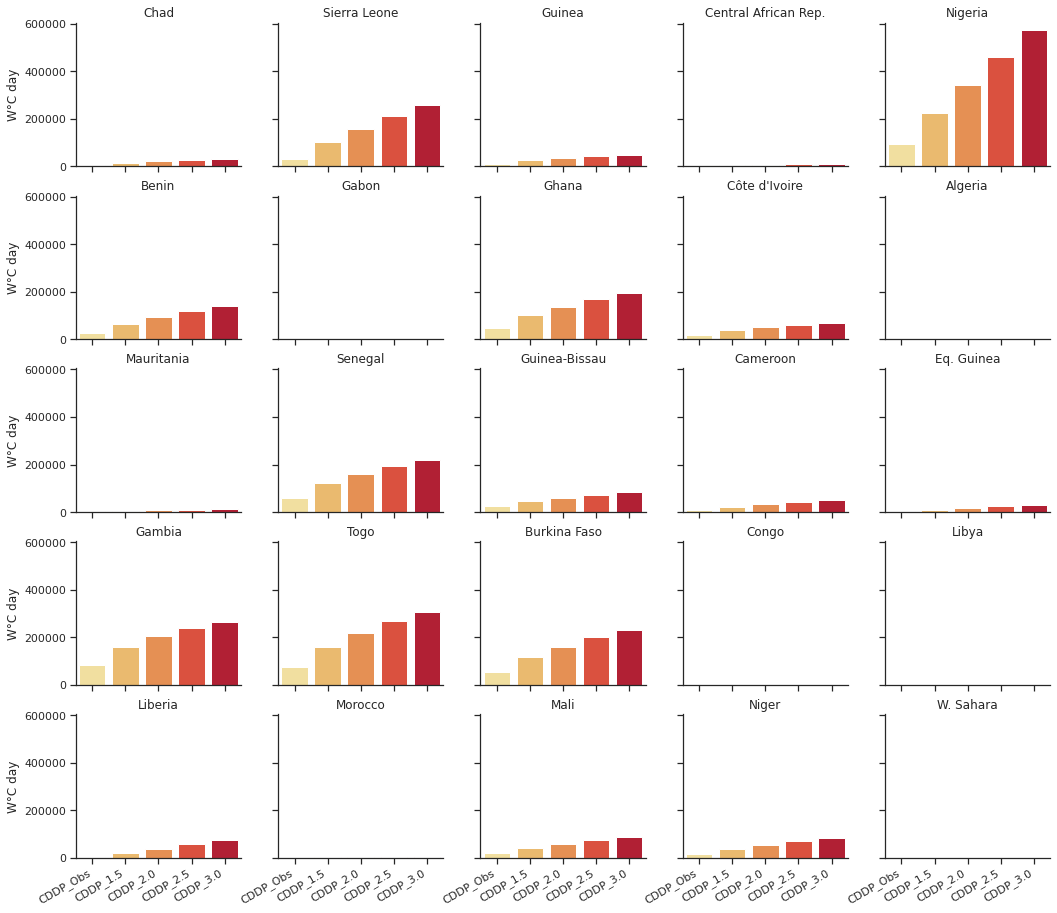

In [379]:
times = cddp_mme_r.cddp_case.unique()
sns.set_theme(style="ticks")
g = sns.FacetGrid(cddp_mme_r, col="Country",col_wrap=5)
g.map(sns.barplot,"cddp_case","value",order=times,palette='YlOrRd')
g.set_titles("{col_name}")
g.set(xlabel=None,ylabel='W\N{DEGREE SIGN}C day')
# g.despine(top=True)
# g.despine(left=True)
g.fig.autofmt_xdate()
plt.savefig('/mys3bucket/cdd_output/Figures/CDDP_country.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDDP_country.png',dpi=300)

## CDD by country and by warming levels

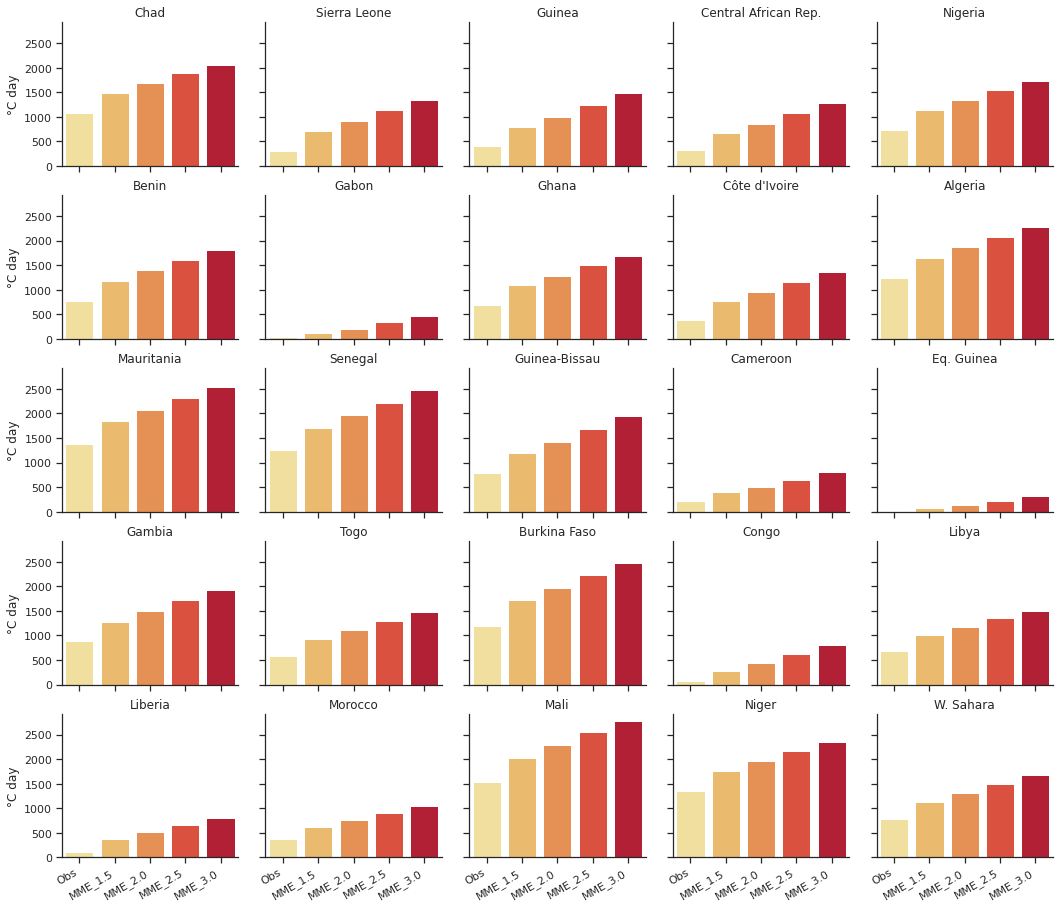

In [380]:
times = cdd_mme_r.cdd_case.unique()
sns.set_theme(style="ticks")
g = sns.FacetGrid(cdd_mme_r, col="Country",col_wrap=5)
g.map(sns.barplot,"cdd_case","value",order=times,palette='YlOrRd')
g.set_titles("{col_name}")
g.set(xlabel=None,ylabel='\N{DEGREE SIGN}C day')
# g.despine(top=True)
# g.despine(left=True)
g.fig.autofmt_xdate()
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_country.eps', format='eps')
plt.savefig('/mys3bucket/cdd_output/Figures/CDD_country.png',dpi=300)